# Solar Radiation Forecasting Models

This notebook implements various deep learning models for Global Horizontal Irradiance (GHI) forecasting using time series weather data. The notebook explores four different model architectures for solar radiation prediction:

1. **LSTM (Long Short-Term Memory)** - Specialized recurrent neural network architecture for sequential data
2. **CNN-LSTM** - Hybrid model combining convolutional layers for feature extraction and LSTM for temporal pattern learning
3. **MLP (Multi-Layer Perceptron)** - Standard feedforward neural network for regression tasks
4. **1D CNN** - Convolutional neural network using 1D convolutions for time series processing
5. **TCN (Temporal Convolutional Network)** - Specialized convolutional architecture with dilated convolutions for sequence modeling

## Prerequisites

**IMPORTANT**: Before running this notebook, you must first run the `2_data_preprocessing.py` script to prepare the normalized data. This script generates the train, validation, and test datasets needed for model training and evaluation.

## Workflow Overview

1. **Data Loading** - Load preprocessed time series datasets
2. **Model Training Setup** - Configure training parameters and utilities
3. **Model Training** - Train multiple model architectures
4. **Performance Evaluation** - Compare models using various metrics
5. **Visualization** - Plot time series predictions and model comparisons

## 0. Debug Mode

**IMPORTANT**: Set to True for code debugging mode and False for actual training.
In debug mode, the code will only run 10 batches/epoch for 10 epochs.

In [1]:
# Debug mode to test code. Set to False for actual training
DEBUG_MODE = False

# 1. Data Loading

In this section, we load and prepare the preprocessed time series data for training our models. The data includes various weather features like temperature, wind speed, solar angles, etc., used to predict the Global Horizontal Irradiance (GHI).

### 1.1 Import modules and define hyperparameters

Here, we define hyperparameters for model training, including the lookback window, batch size, and selected features.

In [2]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 1
%autoreload 2

# Import required libraries
import os
import numpy as np
from datetime import datetime
import json

import torch
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
# Local modules
from utils.data_persistence import load_scalers
from utils.plot_utils import plot_training_history, plot_evaluation_metrics
from utils.training_utils import train_model, evaluate_model, evaluate_inference_time
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info, save_model

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ========== Model training hyperparameters =========
PATIENCE = 5  # Early stopping patience
LR = 0.0001

if DEBUG_MODE:
    # Local debug settings (to check if the code is working)
    # Will only run 10 batches/epoch for 10 epochs
    N_EPOCHS = 10
    BATCH_SIZE = 64
    NUM_WORKERS = 4
else:
    # Remote server settings (to train the model, recommend using Otter lab machine)
    N_EPOCHS = 30
    BATCH_SIZE = 2 ** 13   # = 8192 samples
    NUM_WORKERS = 16

# ================= Wandb settings =============
USE_WANDB = False if DEBUG_MODE else True
WANDB_USERNAME = "tin-hoang"  # Your wandb username
WANDB_PROJECT = "EEEM073-Solar-Radiation"  # Your wandb project name

# =========== Time series hyperparameters ===========
# Number of timesteps to look back when creating sequences
LOOKBACK = 24

# Choose features to use in modeling
TIME_FEATURES = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',      # Categorical feature
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'nighttime_mask',  # New field from preprocess_data
    'cld_opd_dcomp',
    'aod'
]
STATIC_FEATURES = ['latitude', 'longitude', 'elevation']
# Target variable
TARGET_VARIABLE = 'ghi'

Using cuda device


### 1.2 Create PyTorch Datasets and DataLoaders

Here, we set up the PyTorch data pipeline by creating custom datasets and DataLoaders.

In [3]:
# Loading preprocessed data files generated from 2_data_preprocessing.py
# These files contain normalized time series data split into train, validation, and test sets
from utils.data_persistence import load_normalized_data

TRAIN_PREPROCESSED_DATA_PATH = "data/processed/train_normalized_20250430_145157.h5"
VAL_PREPROCESSED_DATA_PATH = "data/processed/val_normalized_20250430_145205.h5"
TEST_PREPROCESSED_DATA_PATH = "data/processed/test_normalized_20250430_145205.h5"

# Load sequences
train_data, metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

SCALER_PATH = "data/processed/scalers_20250430_145206.pkl"
scalers = load_scalers(SCALER_PATH)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")

Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Train set | Metadata: {'created_time': '2025-04-30 14:51:57'}
Train set | Created time: 2025-04-30 14:51:57
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (70128, 105)
  aod shape: (70128, 105)
  cld_opd_dcomp shape: (70128, 105)
  cld_press_acha shape: (70128, 105)
  cld_reff_dcomp shape: (70128, 105)
  clearsky_ghi shape: (70128, 105)
  cloud_type shape: (70128, 105)
  day_cos shape: (70128,)
  day_sin shape: (70128,)
  dow_cos shape: (70128,)
  dow_sin shape: (70128,)
  elevation shape: (105,)
  ghi shape: (70128, 105)
  hour_cos shape: (70128,)
  hour_sin shape: (70128,)
  latitude shape: (105,)
  longitude shape: (105,)
  month_cos shape: (70128,)
  month_sin shape: (70128,)
  nighttime_mask shape: (70128, 105)
  relative_humidity shape: (70128, 105)
  solar_zenith_angle shape: (70128, 105)
  surf

In [4]:
# Creating PyTorch datasets from preprocessed data
# TimeSeriesDataset is a custom dataset class that formats the data for model training
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(TRAIN_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                 selected_features=SELECTED_FEATURES, include_target_history=False,
                                 static_features=STATIC_FEATURES)
val_dataset = TimeSeriesDataset(VAL_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                               selected_features=SELECTED_FEATURES, include_target_history=False,
                               static_features=STATIC_FEATURES)
test_dataset = TimeSeriesDataset(TEST_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                selected_features=SELECTED_FEATURES, include_target_history=False,
                                static_features=STATIC_FEATURES)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using time feature keys: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Using static features: ['latitude', 'longitude', 'elevation']
Not using target field history for autoregression
Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded normalized data file (1/1): data/processed/train_normalized_20250430_145157.h5
Loaded data with 27 features
Using 11 selected features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Temporal features: ['day_cos', 'day_sin', 'dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']
Static features: ['latitude', 'longitude', 'elevation']
Time series features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total

In [5]:
# Examining data dimensions to configure model architectures
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(temporal_features.shape)
STATIC_FEATURES_SHAPE = list(static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")

static_features shape: torch.Size([8192, 3])
target shape: torch.Size([8192])
temporal_features shape: torch.Size([8192, 24, 19])
air_temperature shape: torch.Size([8192, 24])
aod shape: torch.Size([8192, 24])
cld_opd_dcomp shape: torch.Size([8192, 24])
clearsky_ghi shape: torch.Size([8192, 24])
cloud_type shape: torch.Size([8192, 24])
nighttime_mask shape: torch.Size([8192, 24])
relative_humidity shape: torch.Size([8192, 24])
solar_zenith_angle shape: torch.Size([8192, 24])
surface_albedo shape: torch.Size([8192, 24])
total_precipitable_water shape: torch.Size([8192, 24])
wind_speed shape: torch.Size([8192, 24])
time_index_local length: 8192
current_hour_sin shape: torch.Size([8192])
current_hour_cos shape: torch.Size([8192])
current_day_sin shape: torch.Size([8192])
current_day_cos shape: torch.Size([8192])
current_month_sin shape: torch.Size([8192])
current_month_cos shape: torch.Size([8192])
current_dow_sin shape: torch.Size([8192])
current_dow_cos shape: torch.Size([8192])
  Input

## 2. Model Training Setup

This section configures the training environment, including setting up experiment tracking, defining the training pipeline, and preparing evaluation metrics.

## 2.1 Setting Wandb logging (optional)

Weights & Biases (wandb) is used for experiment tracking. Here we configure whether to use wandb for logging model training progress and results.

In [6]:
# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)

True

## 2.2 Setup Experiment Pipeline

We define a standardized pipeline for training and evaluating models. This function handles the entire workflow:
1. Model training with early stopping (use train and val set)
2. Evaluation on test data
3. Saving model checkpoints
4. Logging results to wandb (if enabled)

In [7]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    history, val_metrics, test_metrics = None, None, None

    # Get the current config
    CONFIG = {}
    cur_globals = globals().copy()
    for x in cur_globals:
        # Only get the variables that are uppercase and not digits
        if x.upper() == x and not x.startswith('_') and not x == "CONFIG":
            CONFIG[x] = cur_globals[x]

    try:
        print(f"Training {model_name} model...")
        history = train_model(
            model,
            train_loader,
            val_loader,
            model_name=model_name,
            epochs=epochs,
            patience=patience,
            lr=lr,
            target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
            config=CONFIG,
            device=device,
            debug_mode=DEBUG_MODE,
        )
        training_plot = plot_training_history(history, model_name=model_name)

        print(f"\nEvaluating {model_name} model on test set...")
        test_metrics = evaluate_model(
            model,
            test_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Test",
            device=device,
            debug_mode=DEBUG_MODE,
        )
        # Evaluate inference time
        timing_metrics = evaluate_inference_time(model,
                                                 test_loader,
                                                 model_name=f"{model_name} - Test",
                                                 timing_iterations=3,
                                                 debug_mode=DEBUG_MODE)
        test_metrics.update(timing_metrics)
        test_plot = plot_evaluation_metrics(test_metrics, model_name=f"{model_name} - Test")

        # ========== Save Best Model Checkpoint ===========
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Construct filename with timestamp and directory
        model_filename = f"{model_name}_best_{timestamp}.pt"
        model_path = os.path.join(checkpoint_dir, model_filename)

        # Combine time keys and selected features for the complete temporal feature set
        all_temporal_features = TIME_FEATURES + SELECTED_FEATURES

        # Save the model with metadata using the new save_model function
        save_model(
            model=model,
            filepath=model_path,
            metadata={
                "model_name": model_name,
                "timestamp": timestamp,
                "train_metrics": {
                    "final_train_loss": history["train_loss"][-1] if history and "train_loss" in history else None,
                    "final_train_mae": history["train_mae"][-1] if history and "train_mae" in history else None,
                    "final_val_loss": history["val_loss"][-1] if history and "val_loss" in history else None,
                    "final_val_mae": history["val_mae"][-1] if history and "val_mae" in history else None,
                },
                "test_metrics": {
                    "mse": test_metrics["mse"] if test_metrics else None,
                    "rmse": test_metrics["rmse"] if test_metrics else None,
                    "mae": test_metrics["mae"] if test_metrics else None,
                    "r2": test_metrics["r2"] if test_metrics else None,
                    "mase": test_metrics["mase"] if test_metrics else None,
                }
            },
            temporal_features=all_temporal_features,
            static_features=STATIC_FEATURES,
            time_feature_keys=TIME_FEATURES,
            config=CONFIG
        )

        print(f"Best model saved to {model_path}")

        # Log saved model path to wandb if enabled
        if is_wandb_enabled():
            wandb.save(model_path)
            print(f"Saved model checkpoint logged to wandb: {model_path}")
            wandb.log({"plots/history_plot": wandb.Image(training_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

    finally:
        # Finish wandb run if it's still open
        if is_wandb_enabled():
            wandb.finish()

        # Clear GPU memory
        torch.cuda.empty_cache()

    return history, val_metrics, test_metrics

# 3. Model Experiments

This section implements and trains different neural network architectures for GHI forecasting. Each model is trained using the same pipeline for fair comparison.

### 3.1 LSTM Model

The Long Short-Term Memory (LSTM) network is a type of recurrent neural network well-suited for time series forecasting.
It's designed to capture long-term dependencies in sequential data through specialized memory cells.

For detailed model code: `models/lstm.py`

In [8]:
from models.lstm import LSTMModel

# Create LSTM model
lstm_model = LSTMModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dim=128,
    num_layers=2,
    dropout=0.2,
    bidirectional=False
).to(device)

# Print the model
print_model_info(lstm_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: LSTMModel
Total parameters: 221,441
Trainable parameters: 221,441
Non-trainable parameters: 0

Model structure:
LSTMModel(
  (lstm): LSTM(19, 128, num_layers=2, batch_first=True, dropout=0.2)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (static_proj): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True,

Training LSTM model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for LSTM


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation LSTM (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 5168.34, RMSE: 71.89, MAE: 41.63, R²: 0.9436, MASE: 0.88
  Daytime:  MSE: 10211.36, RMSE: 101.05, MAE: 73.00, R²: 0.8721, MASE: 0.77
  Nighttime: MSE: 162.14, RMSE: 12.73, MAE: 10.50, R²: -59.6669, MASE: 101.91
Epoch 1/30 | Train Loss: 33397.6406, Train MAE: 132.1115 | Val Loss: 5168.3354, Val MAE: 41.6309 | LR: 0.000100



Validation LSTM (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 4408.04, RMSE: 66.39, MAE: 37.43, R²: 0.9519, MASE: 0.79
  Daytime:  MSE: 8795.55, RMSE: 93.78, MAE: 68.99, R²: 0.8899, MASE: 0.73
  Nighttime: MSE: 52.57, RMSE: 7.25, MAE: 6.09, R²: -18.6707, MASE: 59.17
Epoch 2/30 | Train Loss: 8481.5537, Train MAE: 59.8421 | Val Loss: 4408.0381, Val MAE: 37.4282 | LR: 0.000100



Validation LSTM (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3523.68, RMSE: 59.36, MAE: 30.26, R²: 0.9615, MASE: 0.64
  Daytime:  MSE: 7052.55, RMSE: 83.98, MAE: 57.26, R²: 0.9117, MASE: 0.60
  Nighttime: MSE: 20.59, RMSE: 4.54, MAE: 3.46, R²: -6.7033, MASE: 33.56
Epoch 3/30 | Train Loss: 6556.7778, Train MAE: 51.5848 | Val Loss: 3523.6799, Val MAE: 30.2587 | LR: 0.000100



Validation LSTM (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3284.89, RMSE: 57.31, MAE: 28.17, R²: 0.9642, MASE: 0.60
  Daytime:  MSE: 6580.46, RMSE: 81.12, MAE: 54.35, R²: 0.9176, MASE: 0.57
  Nighttime: MSE: 13.38, RMSE: 3.66, MAE: 2.19, R²: -4.0073, MASE: 21.26
Epoch 4/30 | Train Loss: 5778.8110, Train MAE: 48.3824 | Val Loss: 3284.8850, Val MAE: 28.1746 | LR: 0.000100



Validation LSTM (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3206.82, RMSE: 56.63, MAE: 28.06, R²: 0.9650, MASE: 0.59
  Daytime:  MSE: 6423.65, RMSE: 80.15, MAE: 54.08, R²: 0.9196, MASE: 0.57
  Nighttime: MSE: 13.49, RMSE: 3.67, MAE: 2.22, R²: -4.0482, MASE: 21.60
Epoch 5/30 | Train Loss: 5451.6001, Train MAE: 46.9634 | Val Loss: 3206.8242, Val MAE: 28.0590 | LR: 0.000100



Validation LSTM (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3144.72, RMSE: 56.08, MAE: 27.11, R²: 0.9657, MASE: 0.57
  Daytime:  MSE: 6298.97, RMSE: 79.37, MAE: 52.18, R²: 0.9211, MASE: 0.55
  Nighttime: MSE: 13.50, RMSE: 3.67, MAE: 2.23, R²: -4.0492, MASE: 21.63
Epoch 6/30 | Train Loss: 5262.9653, Train MAE: 46.0000 | Val Loss: 3144.7158, Val MAE: 27.1099 | LR: 0.000100



Validation LSTM (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3455.21, RMSE: 58.78, MAE: 31.78, R²: 0.9623, MASE: 0.67
  Daytime:  MSE: 6913.10, RMSE: 83.15, MAE: 61.01, R²: 0.9134, MASE: 0.64
  Nighttime: MSE: 22.57, RMSE: 4.75, MAE: 2.76, R²: -7.4450, MASE: 26.82
Epoch 7/30 | Train Loss: 5120.4858, Train MAE: 45.2246 | Val Loss: 3455.2102, Val MAE: 31.7784 | LR: 0.000100



Validation LSTM (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3180.82, RMSE: 56.40, MAE: 26.84, R²: 0.9653, MASE: 0.57
  Daytime:  MSE: 6365.30, RMSE: 79.78, MAE: 50.28, R²: 0.9203, MASE: 0.53
  Nighttime: MSE: 19.59, RMSE: 4.43, MAE: 3.57, R²: -6.3283, MASE: 34.65
Epoch 8/30 | Train Loss: 5027.4756, Train MAE: 44.6261 | Val Loss: 3180.8159, Val MAE: 26.8391 | LR: 0.000100



Validation LSTM (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3135.54, RMSE: 56.00, MAE: 26.59, R²: 0.9658, MASE: 0.56
  Daytime:  MSE: 6274.45, RMSE: 79.21, MAE: 50.31, R²: 0.9214, MASE: 0.53
  Nighttime: MSE: 19.55, RMSE: 4.42, MAE: 3.04, R²: -6.3158, MASE: 29.55
Epoch 9/30 | Train Loss: 4929.6963, Train MAE: 43.9958 | Val Loss: 3135.5400, Val MAE: 26.5892 | LR: 0.000100



Validation LSTM (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3084.07, RMSE: 55.53, MAE: 27.63, R²: 0.9663, MASE: 0.58
  Daytime:  MSE: 6163.71, RMSE: 78.51, MAE: 50.86, R²: 0.9228, MASE: 0.54
  Nighttime: MSE: 26.93, RMSE: 5.19, MAE: 4.57, R²: -9.0752, MASE: 44.34
Epoch 10/30 | Train Loss: 4866.7983, Train MAE: 43.5787 | Val Loss: 3084.0742, Val MAE: 27.6299 | LR: 0.000100



Validation LSTM (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3061.79, RMSE: 55.33, MAE: 25.74, R²: 0.9666, MASE: 0.55
  Daytime:  MSE: 6135.89, RMSE: 78.33, MAE: 49.69, R²: 0.9232, MASE: 0.52
  Nighttime: MSE: 10.14, RMSE: 3.18, MAE: 1.97, R²: -2.7941, MASE: 19.16
Epoch 11/30 | Train Loss: 4794.5732, Train MAE: 43.0842 | Val Loss: 3061.7891, Val MAE: 25.7450 | LR: 0.000100



Validation LSTM (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3114.23, RMSE: 55.81, MAE: 28.41, R²: 0.9660, MASE: 0.60
  Daytime:  MSE: 6237.87, RMSE: 78.98, MAE: 53.86, R²: 0.9219, MASE: 0.57
  Nighttime: MSE: 13.42, RMSE: 3.66, MAE: 3.16, R²: -4.0197, MASE: 30.65
Epoch 12/30 | Train Loss: 4748.1348, Train MAE: 42.7781 | Val Loss: 3114.2332, Val MAE: 28.4131 | LR: 0.000100



Validation LSTM (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3167.45, RMSE: 56.28, MAE: 26.55, R²: 0.9654, MASE: 0.56
  Daytime:  MSE: 6341.51, RMSE: 79.63, MAE: 49.57, R²: 0.9206, MASE: 0.52
  Nighttime: MSE: 16.57, RMSE: 4.07, MAE: 3.70, R²: -5.2014, MASE: 35.94
Epoch 13/30 | Train Loss: 4723.4121, Train MAE: 42.5864 | Val Loss: 3167.4507, Val MAE: 26.5537 | LR: 0.000100



Validation LSTM (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3157.07, RMSE: 56.19, MAE: 29.13, R²: 0.9655, MASE: 0.62
  Daytime:  MSE: 6318.10, RMSE: 79.49, MAE: 54.50, R²: 0.9209, MASE: 0.58
  Nighttime: MSE: 19.12, RMSE: 4.37, MAE: 3.95, R²: -6.1536, MASE: 38.33
Epoch 14/30 | Train Loss: 4676.3604, Train MAE: 42.3022 | Val Loss: 3157.0679, Val MAE: 29.1295 | LR: 0.000100



Validation LSTM (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3018.47, RMSE: 54.94, MAE: 27.44, R²: 0.9671, MASE: 0.58
  Daytime:  MSE: 6033.53, RMSE: 77.68, MAE: 50.49, R²: 0.9245, MASE: 0.53
  Nighttime: MSE: 25.44, RMSE: 5.04, MAE: 4.56, R²: -8.5190, MASE: 44.24
Epoch 15/30 | Train Loss: 4655.4497, Train MAE: 42.1715 | Val Loss: 3018.4736, Val MAE: 27.4371 | LR: 0.000100



Validation LSTM (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3043.43, RMSE: 55.17, MAE: 25.67, R²: 0.9668, MASE: 0.54
  Daytime:  MSE: 6097.77, RMSE: 78.09, MAE: 48.51, R²: 0.9237, MASE: 0.51
  Nighttime: MSE: 11.40, RMSE: 3.38, MAE: 3.00, R²: -3.2649, MASE: 29.12
Epoch 16/30 | Train Loss: 4624.3555, Train MAE: 41.9618 | Val Loss: 3043.4280, Val MAE: 25.6693 | LR: 0.000100



Validation LSTM (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3033.76, RMSE: 55.08, MAE: 27.28, R²: 0.9669, MASE: 0.58
  Daytime:  MSE: 6071.68, RMSE: 77.92, MAE: 51.16, R²: 0.9240, MASE: 0.54
  Nighttime: MSE: 18.02, RMSE: 4.24, MAE: 3.58, R²: -5.7419, MASE: 34.76
Epoch 17/30 | Train Loss: 4600.2686, Train MAE: 41.8347 | Val Loss: 3033.7581, Val MAE: 27.2805 | LR: 0.000100



Validation LSTM (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2999.27, RMSE: 54.77, MAE: 25.92, R²: 0.9673, MASE: 0.55
  Daytime:  MSE: 6008.88, RMSE: 77.52, MAE: 49.15, R²: 0.9248, MASE: 0.52
  Nighttime: MSE: 11.65, RMSE: 3.41, MAE: 2.87, R²: -3.3584, MASE: 27.84
Epoch 18/30 | Train Loss: 4580.5117, Train MAE: 41.6881 | Val Loss: 2999.2739, Val MAE: 25.9229 | LR: 0.000100



Validation LSTM (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 3072.81, RMSE: 55.43, MAE: 27.79, R²: 0.9665, MASE: 0.59
  Daytime:  MSE: 6151.60, RMSE: 78.43, MAE: 52.18, R²: 0.9230, MASE: 0.55
  Nighttime: MSE: 16.50, RMSE: 4.06, MAE: 3.59, R²: -5.1726, MASE: 34.85
Epoch 19/30 | Train Loss: 4559.8579, Train MAE: 41.5600 | Val Loss: 3072.8079, Val MAE: 27.7941 | LR: 0.000100



Validation LSTM (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2999.94, RMSE: 54.77, MAE: 26.93, R²: 0.9673, MASE: 0.57
  Daytime:  MSE: 6003.88, RMSE: 77.48, MAE: 50.02, R²: 0.9248, MASE: 0.53
  Nighttime: MSE: 17.94, RMSE: 4.24, MAE: 4.02, R²: -5.7114, MASE: 38.99
Epoch 20/30 | Train Loss: 4539.0557, Train MAE: 41.4579 | Val Loss: 2999.9407, Val MAE: 26.9340 | LR: 0.000100



Validation LSTM (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 3086.40, RMSE: 55.56, MAE: 26.01, R²: 0.9663, MASE: 0.55
  Daytime:  MSE: 6177.56, RMSE: 78.60, MAE: 48.20, R²: 0.9227, MASE: 0.51
  Nighttime: MSE: 17.81, RMSE: 4.22, MAE: 3.98, R²: -5.6653, MASE: 38.67
Epoch 21/30 | Train Loss: 4539.5088, Train MAE: 41.4452 | Val Loss: 3086.3970, Val MAE: 26.0079 | LR: 0.000100



Validation LSTM (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 3017.22, RMSE: 54.93, MAE: 27.82, R²: 0.9671, MASE: 0.59
  Daytime:  MSE: 6037.09, RMSE: 77.70, MAE: 51.56, R²: 0.9244, MASE: 0.54
  Nighttime: MSE: 19.41, RMSE: 4.41, MAE: 4.26, R²: -6.2625, MASE: 41.37
Epoch 22/30 | Train Loss: 4501.4331, Train MAE: 41.1918 | Val Loss: 3017.2229, Val MAE: 27.8250 | LR: 0.000100



Validation LSTM (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2985.71, RMSE: 54.64, MAE: 25.80, R²: 0.9674, MASE: 0.55
  Daytime:  MSE: 5978.87, RMSE: 77.32, MAE: 48.56, R²: 0.9251, MASE: 0.51
  Nighttime: MSE: 14.40, RMSE: 3.79, MAE: 3.22, R²: -4.3869, MASE: 31.24
Epoch 23/30 | Train Loss: 4682.3833, Train MAE: 41.9951 | Val Loss: 2985.7058, Val MAE: 25.8047 | LR: 0.000100



Validation LSTM (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2986.54, RMSE: 54.65, MAE: 26.69, R²: 0.9674, MASE: 0.57
  Daytime:  MSE: 5979.36, RMSE: 77.33, MAE: 49.80, R²: 0.9251, MASE: 0.53
  Nighttime: MSE: 15.58, RMSE: 3.95, MAE: 3.75, R²: -4.8297, MASE: 36.44
Epoch 24/30 | Train Loss: 4480.7842, Train MAE: 41.0129 | Val Loss: 2986.5430, Val MAE: 26.6908 | LR: 0.000100



Validation LSTM (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2976.58, RMSE: 54.56, MAE: 25.93, R²: 0.9675, MASE: 0.55
  Daytime:  MSE: 5962.67, RMSE: 77.22, MAE: 48.76, R²: 0.9253, MASE: 0.51
  Nighttime: MSE: 12.30, RMSE: 3.51, MAE: 3.26, R²: -3.6022, MASE: 31.64
Epoch 25/30 | Train Loss: 4474.2817, Train MAE: 40.9637 | Val Loss: 2976.5806, Val MAE: 25.9282 | LR: 0.000100



Validation LSTM (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 3027.88, RMSE: 55.03, MAE: 27.48, R²: 0.9670, MASE: 0.58
  Daytime:  MSE: 6067.40, RMSE: 77.89, MAE: 52.11, R²: 0.9240, MASE: 0.55
  Nighttime: MSE: 10.55, RMSE: 3.25, MAE: 3.02, R²: -2.9486, MASE: 29.30
Epoch 26/30 | Train Loss: 4465.1880, Train MAE: 40.9096 | Val Loss: 3027.8770, Val MAE: 27.4751 | LR: 0.000100



Validation LSTM (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 3105.08, RMSE: 55.72, MAE: 28.43, R²: 0.9661, MASE: 0.60
  Daytime:  MSE: 6218.18, RMSE: 78.86, MAE: 53.33, R²: 0.9221, MASE: 0.56
  Nighttime: MSE: 14.73, RMSE: 3.84, MAE: 3.70, R²: -4.5103, MASE: 35.90
Epoch 27/30 | Train Loss: 4454.8325, Train MAE: 40.8430 | Val Loss: 3105.0837, Val MAE: 28.4250 | LR: 0.000100



Validation LSTM (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 3033.38, RMSE: 55.08, MAE: 27.37, R²: 0.9669, MASE: 0.58
  Daytime:  MSE: 6074.90, RMSE: 77.94, MAE: 51.66, R²: 0.9239, MASE: 0.55
  Nighttime: MSE: 14.09, RMSE: 3.75, MAE: 3.27, R²: -4.2704, MASE: 31.73
Epoch 28/30 | Train Loss: 4448.5410, Train MAE: 40.8048 | Val Loss: 3033.3835, Val MAE: 27.3736 | LR: 0.000100



Validation LSTM (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 2978.95, RMSE: 54.58, MAE: 26.22, R²: 0.9675, MASE: 0.56
  Daytime:  MSE: 5965.11, RMSE: 77.23, MAE: 49.02, R²: 0.9253, MASE: 0.52
  Nighttime: MSE: 14.60, RMSE: 3.82, MAE: 3.59, R²: -4.4624, MASE: 34.82
Epoch 29/30 | Train Loss: 4434.4985, Train MAE: 40.7191 | Val Loss: 2978.9504, Val MAE: 26.2206 | LR: 0.000100



Validation LSTM (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 2991.04, RMSE: 54.69, MAE: 26.97, R²: 0.9674, MASE: 0.57
  Daytime:  MSE: 5990.82, RMSE: 77.40, MAE: 50.63, R²: 0.9250, MASE: 0.53
  Nighttime: MSE: 13.18, RMSE: 3.63, MAE: 3.48, R²: -3.9298, MASE: 33.84
Epoch 30/30 | Train Loss: 4425.8882, Train MAE: 40.6752 | Val Loss: 2991.0403, Val MAE: 26.9712 | LR: 0.000100
Early stopping at epoch 30
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


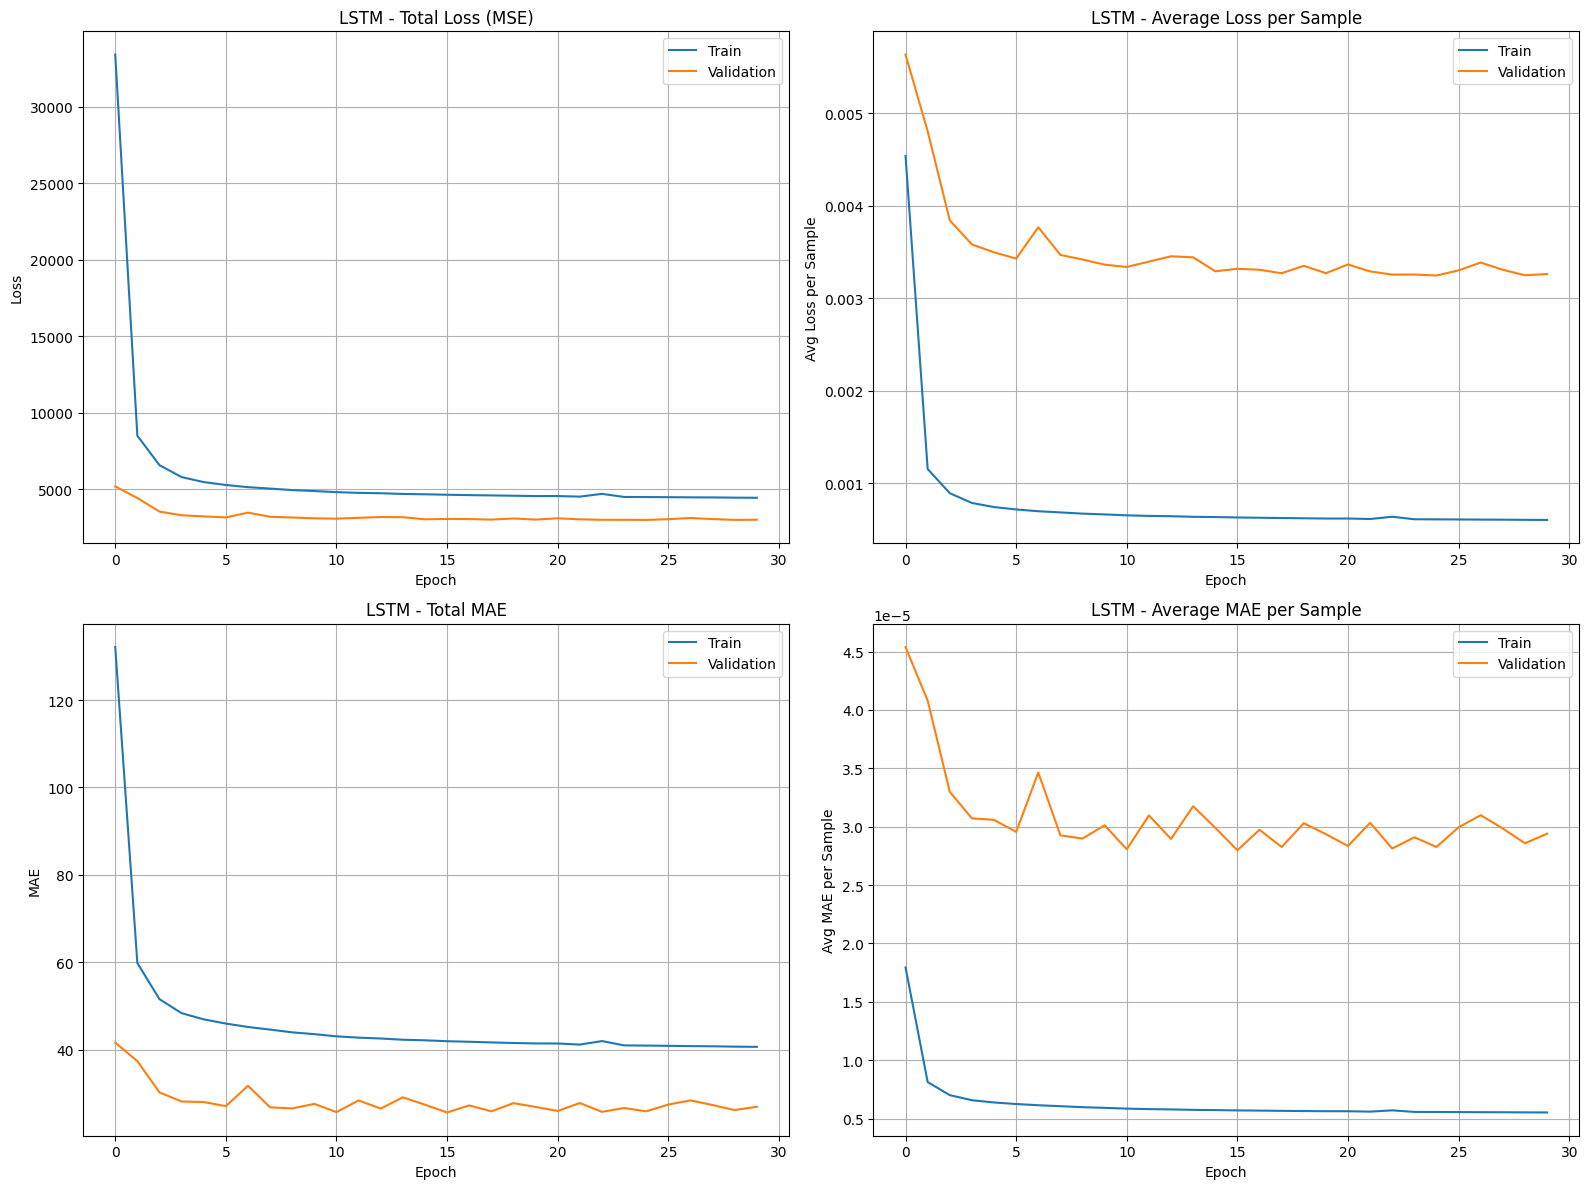


Evaluating LSTM model on test set...



LSTM - Test Evaluation Metrics:
  Overall:  MSE: 2859.22, RMSE: 53.47, MAE: 26.87, R²: 0.9691, MASE: 0.53
  Daytime:  MSE: 5726.30, RMSE: 75.67, MAE: 50.41, R²: 0.9304, MASE: 0.50
  Nighttime: MSE: 13.30, RMSE: 3.65, MAE: 3.50, R²: -4.0996, MASE: 34.46



LSTM - Test Timing Metrics:
  Inference Speed: 215547.28 samples/sec, 4.6394 μs/sample
  Total time: 4.2673 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0100s, max=0.0389s, std=0.0028s
Model saved to checkpoints/LSTM_best_20250507_200145.pt with metadata.
Best model saved to checkpoints/LSTM_best_20250507_200145.pt
Saved model checkpoint logged to wandb: checkpoints/LSTM_best_20250507_200145.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/timing_iterations,▁
test/timing_warmup_enabled,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


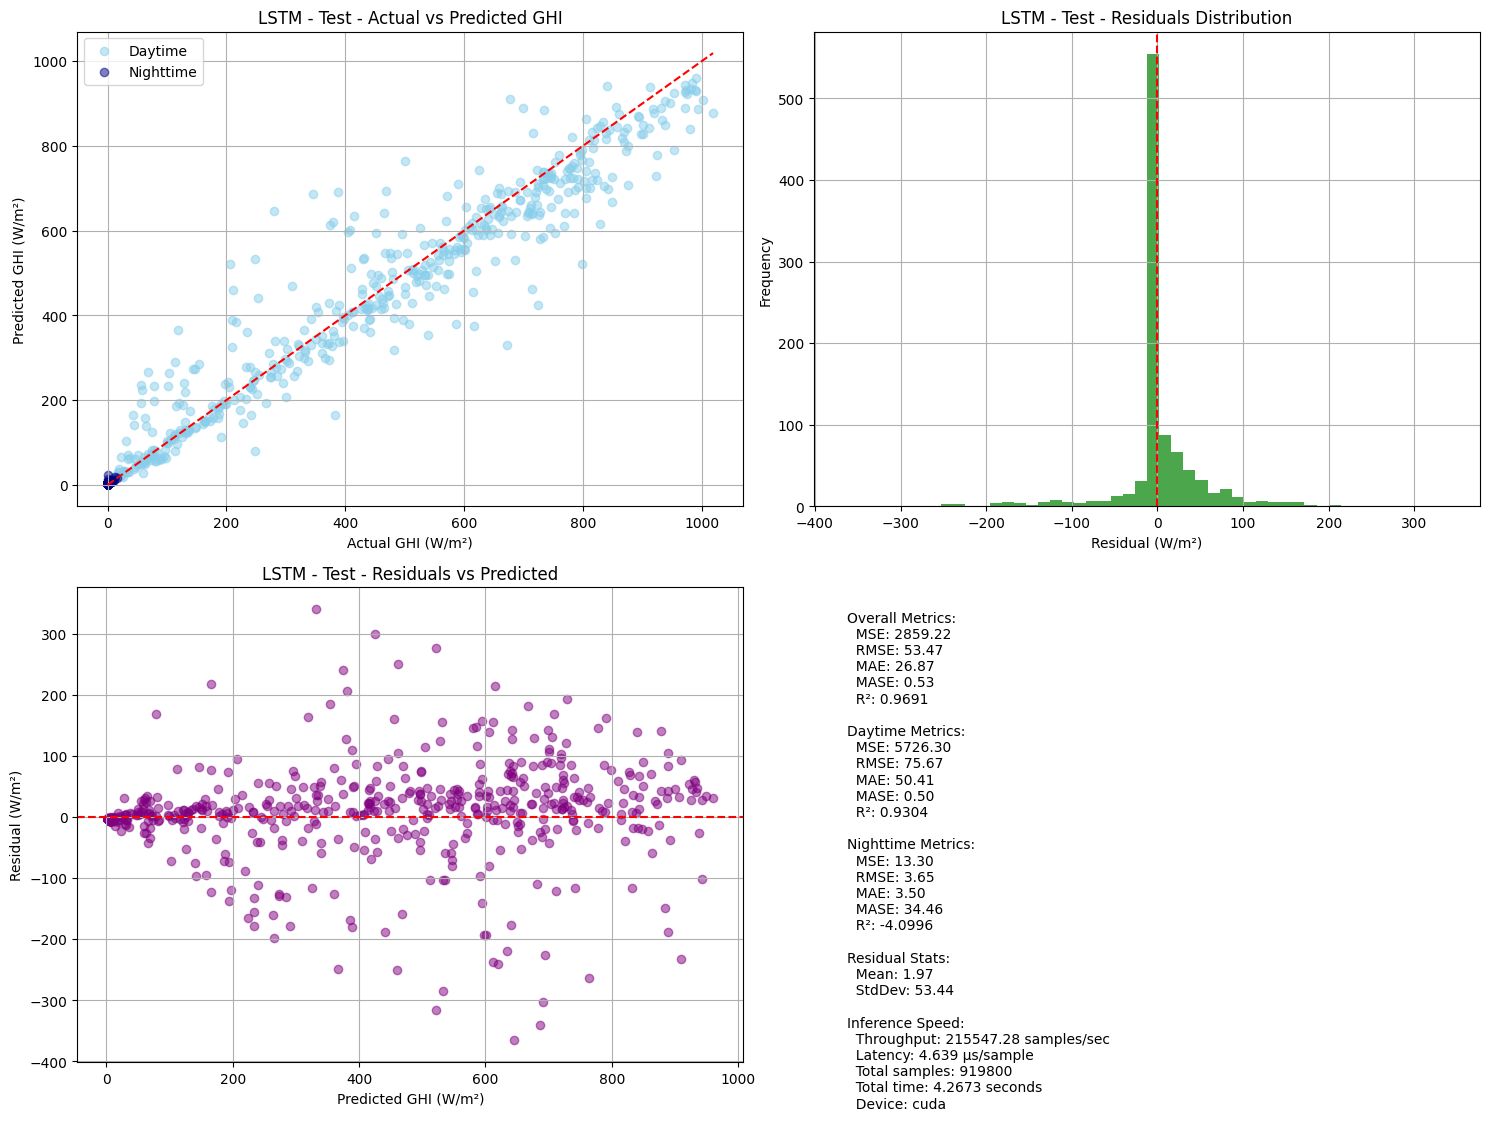

In [9]:
model_name = "LSTM"

# Train the LSTM model
lstm_history, lstm_val_metrics, lstm_test_metrics = run_experiment_pipeline(
    lstm_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.2 CNN-LSTM Model

The CNN-LSTM model combines convolutional layers with LSTM layers. The CNN component extracts features from the input data,
which are then fed into LSTM layers to capture temporal patterns. This hybrid approach can be effective for time series with spatial correlations.

For detailed model code: `models/cnn_lstm.py`

In [10]:
from models.cnn_lstm import CNNLSTMModel

# Create CNN-LSTM model
cnn_lstm_model = CNNLSTMModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dim=128,
    num_filters=64,
    kernel_size=3,
    num_layers=2,
    dropout=0.2,
    bidirectional=False
).to(device)

# Print the model
print_model_info(cnn_lstm_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: CNNLSTMModel
Total parameters: 306,049
Trainable parameters: 306,049
Non-trainable parameters: 0

Model structure:
CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (static_proj): Sequential(
    

Training CNN-LSTM model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for CNN-LSTM


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation CNN-LSTM (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4673.32, RMSE: 68.36, MAE: 43.11, R²: 0.9490, MASE: 0.91
  Daytime:  MSE: 8881.21, RMSE: 94.24, MAE: 67.62, R²: 0.8888, MASE: 0.71
  Nighttime: MSE: 496.18, RMSE: 22.28, MAE: 18.79, R²: -184.6465, MASE: 182.44
Epoch 1/30 | Train Loss: 41499.7109, Train MAE: 143.4938 | Val Loss: 4673.3247, Val MAE: 43.1125 | LR: 0.000100



Validation CNN-LSTM (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3605.23, RMSE: 60.04, MAE: 33.39, R²: 0.9607, MASE: 0.71
  Daytime:  MSE: 7144.71, RMSE: 84.53, MAE: 59.27, R²: 0.9105, MASE: 0.63
  Nighttime: MSE: 91.59, RMSE: 9.57, MAE: 7.69, R²: -33.2701, MASE: 74.70
Epoch 2/30 | Train Loss: 8003.2563, Train MAE: 55.1073 | Val Loss: 3605.2256, Val MAE: 33.3893 | LR: 0.000100



Validation CNN-LSTM (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3364.60, RMSE: 58.01, MAE: 30.49, R²: 0.9633, MASE: 0.65
  Daytime:  MSE: 6715.18, RMSE: 81.95, MAE: 56.57, R²: 0.9159, MASE: 0.60
  Nighttime: MSE: 38.49, RMSE: 6.20, MAE: 4.59, R²: -13.3997, MASE: 44.60
Epoch 3/30 | Train Loss: 6250.7568, Train MAE: 46.6953 | Val Loss: 3364.5984, Val MAE: 30.4876 | LR: 0.000100



Validation CNN-LSTM (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3285.80, RMSE: 57.32, MAE: 29.58, R²: 0.9641, MASE: 0.63
  Daytime:  MSE: 6566.19, RMSE: 81.03, MAE: 55.58, R²: 0.9178, MASE: 0.59
  Nighttime: MSE: 29.36, RMSE: 5.42, MAE: 3.77, R²: -9.9861, MASE: 36.57
Epoch 4/30 | Train Loss: 5707.4712, Train MAE: 44.4415 | Val Loss: 3285.7966, Val MAE: 29.5771 | LR: 0.000100



Validation CNN-LSTM (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3247.02, RMSE: 56.98, MAE: 29.01, R²: 0.9646, MASE: 0.61
  Daytime:  MSE: 6493.90, RMSE: 80.58, MAE: 55.72, R²: 0.9187, MASE: 0.59
  Nighttime: MSE: 23.86, RMSE: 4.88, MAE: 2.50, R²: -7.9272, MASE: 24.31
Epoch 5/30 | Train Loss: 5347.6567, Train MAE: 43.1101 | Val Loss: 3247.0210, Val MAE: 29.0127 | LR: 0.000100



Validation CNN-LSTM (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3284.58, RMSE: 57.31, MAE: 28.95, R²: 0.9642, MASE: 0.61
  Daytime:  MSE: 6575.03, RMSE: 81.09, MAE: 56.55, R²: 0.9177, MASE: 0.60
  Nighttime: MSE: 18.16, RMSE: 4.26, MAE: 1.55, R²: -5.7955, MASE: 15.08
Epoch 6/30 | Train Loss: 5074.5571, Train MAE: 42.0928 | Val Loss: 3284.5781, Val MAE: 28.9492 | LR: 0.000100



Validation CNN-LSTM (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3188.81, RMSE: 56.47, MAE: 28.56, R²: 0.9652, MASE: 0.60
  Daytime:  MSE: 6384.55, RMSE: 79.90, MAE: 54.79, R²: 0.9201, MASE: 0.58
  Nighttime: MSE: 16.40, RMSE: 4.05, MAE: 2.52, R²: -5.1372, MASE: 24.48
Epoch 7/30 | Train Loss: 4857.2139, Train MAE: 41.4552 | Val Loss: 3188.8057, Val MAE: 28.5620 | LR: 0.000100



Validation CNN-LSTM (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3170.64, RMSE: 56.31, MAE: 28.51, R²: 0.9654, MASE: 0.60
  Daytime:  MSE: 6338.01, RMSE: 79.61, MAE: 54.17, R²: 0.9206, MASE: 0.57
  Nighttime: MSE: 26.40, RMSE: 5.14, MAE: 3.04, R²: -8.8767, MASE: 29.47
Epoch 8/30 | Train Loss: 4689.1714, Train MAE: 40.9923 | Val Loss: 3170.6350, Val MAE: 28.5084 | LR: 0.000100



Validation CNN-LSTM (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3225.56, RMSE: 56.79, MAE: 29.01, R²: 0.9648, MASE: 0.61
  Daytime:  MSE: 6450.14, RMSE: 80.31, MAE: 55.12, R²: 0.9192, MASE: 0.58
  Nighttime: MSE: 24.53, RMSE: 4.95, MAE: 3.10, R²: -8.1782, MASE: 30.09
Epoch 9/30 | Train Loss: 4599.7764, Train MAE: 40.7887 | Val Loss: 3225.5581, Val MAE: 29.0116 | LR: 0.000100



Validation CNN-LSTM (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3433.56, RMSE: 58.60, MAE: 31.25, R²: 0.9625, MASE: 0.66
  Daytime:  MSE: 6870.12, RMSE: 82.89, MAE: 58.84, R²: 0.9140, MASE: 0.62
  Nighttime: MSE: 22.10, RMSE: 4.70, MAE: 3.87, R²: -7.2676, MASE: 37.57
Epoch 10/30 | Train Loss: 4514.2979, Train MAE: 40.5293 | Val Loss: 3433.5562, Val MAE: 31.2549 | LR: 0.000100



Validation CNN-LSTM (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3222.75, RMSE: 56.77, MAE: 28.77, R²: 0.9648, MASE: 0.61
  Daytime:  MSE: 6452.00, RMSE: 80.32, MAE: 55.29, R²: 0.9192, MASE: 0.58
  Nighttime: MSE: 17.08, RMSE: 4.13, MAE: 2.44, R²: -5.3920, MASE: 23.66
Epoch 11/30 | Train Loss: 4461.9614, Train MAE: 40.4592 | Val Loss: 3222.7517, Val MAE: 28.7651 | LR: 0.000100



Validation CNN-LSTM (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3410.28, RMSE: 58.40, MAE: 30.65, R²: 0.9628, MASE: 0.65
  Daytime:  MSE: 6820.71, RMSE: 82.59, MAE: 58.06, R²: 0.9146, MASE: 0.61
  Nighttime: MSE: 24.76, RMSE: 4.98, MAE: 3.44, R²: -8.2658, MASE: 33.37
Epoch 12/30 | Train Loss: 4422.9517, Train MAE: 40.4268 | Val Loss: 3410.2820, Val MAE: 30.6499 | LR: 0.000100



Validation CNN-LSTM (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3141.02, RMSE: 56.04, MAE: 28.87, R²: 0.9657, MASE: 0.61
  Daytime:  MSE: 6261.82, RMSE: 79.13, MAE: 52.96, R²: 0.9216, MASE: 0.56
  Nighttime: MSE: 43.01, RMSE: 6.56, MAE: 4.95, R²: -15.0928, MASE: 48.06
Epoch 13/30 | Train Loss: 4379.7661, Train MAE: 40.3748 | Val Loss: 3141.0161, Val MAE: 28.8660 | LR: 0.000100



Validation CNN-LSTM (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3198.58, RMSE: 56.56, MAE: 29.16, R²: 0.9651, MASE: 0.62
  Daytime:  MSE: 6392.60, RMSE: 79.95, MAE: 54.22, R²: 0.9200, MASE: 0.57
  Nighttime: MSE: 27.88, RMSE: 5.28, MAE: 4.29, R²: -9.4301, MASE: 41.70
Epoch 14/30 | Train Loss: 4336.9092, Train MAE: 40.2532 | Val Loss: 3198.5764, Val MAE: 29.1637 | LR: 0.000100



Validation CNN-LSTM (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3158.34, RMSE: 56.20, MAE: 28.46, R²: 0.9655, MASE: 0.60
  Daytime:  MSE: 6317.22, RMSE: 79.48, MAE: 53.56, R²: 0.9209, MASE: 0.57
  Nighttime: MSE: 22.53, RMSE: 4.75, MAE: 3.54, R²: -7.4303, MASE: 34.38
Epoch 15/30 | Train Loss: 4291.7905, Train MAE: 40.1130 | Val Loss: 3158.3416, Val MAE: 28.4607 | LR: 0.000100



Validation CNN-LSTM (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3200.94, RMSE: 56.58, MAE: 28.08, R²: 0.9651, MASE: 0.59
  Daytime:  MSE: 6409.66, RMSE: 80.06, MAE: 53.24, R²: 0.9197, MASE: 0.56
  Nighttime: MSE: 15.66, RMSE: 3.96, MAE: 3.10, R²: -4.8578, MASE: 30.12
Epoch 16/30 | Train Loss: 4258.5308, Train MAE: 40.0282 | Val Loss: 3200.9409, Val MAE: 28.0814 | LR: 0.000100



Validation CNN-LSTM (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3203.80, RMSE: 56.60, MAE: 28.57, R²: 0.9650, MASE: 0.60
  Daytime:  MSE: 6405.68, RMSE: 80.04, MAE: 53.55, R²: 0.9198, MASE: 0.57
  Nighttime: MSE: 25.31, RMSE: 5.03, MAE: 3.78, R²: -8.4699, MASE: 36.72
Epoch 17/30 | Train Loss: 4220.8999, Train MAE: 39.9033 | Val Loss: 3203.8025, Val MAE: 28.5727 | LR: 0.000100



Validation CNN-LSTM (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 3374.21, RMSE: 58.09, MAE: 30.09, R²: 0.9632, MASE: 0.64
  Daytime:  MSE: 6749.30, RMSE: 82.15, MAE: 56.97, R²: 0.9155, MASE: 0.60
  Nighttime: MSE: 23.78, RMSE: 4.88, MAE: 3.40, R²: -7.8969, MASE: 32.97
Epoch 18/30 | Train Loss: 4188.3081, Train MAE: 39.8126 | Val Loss: 3374.2144, Val MAE: 30.0864 | LR: 0.000100
Early stopping at epoch 18
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


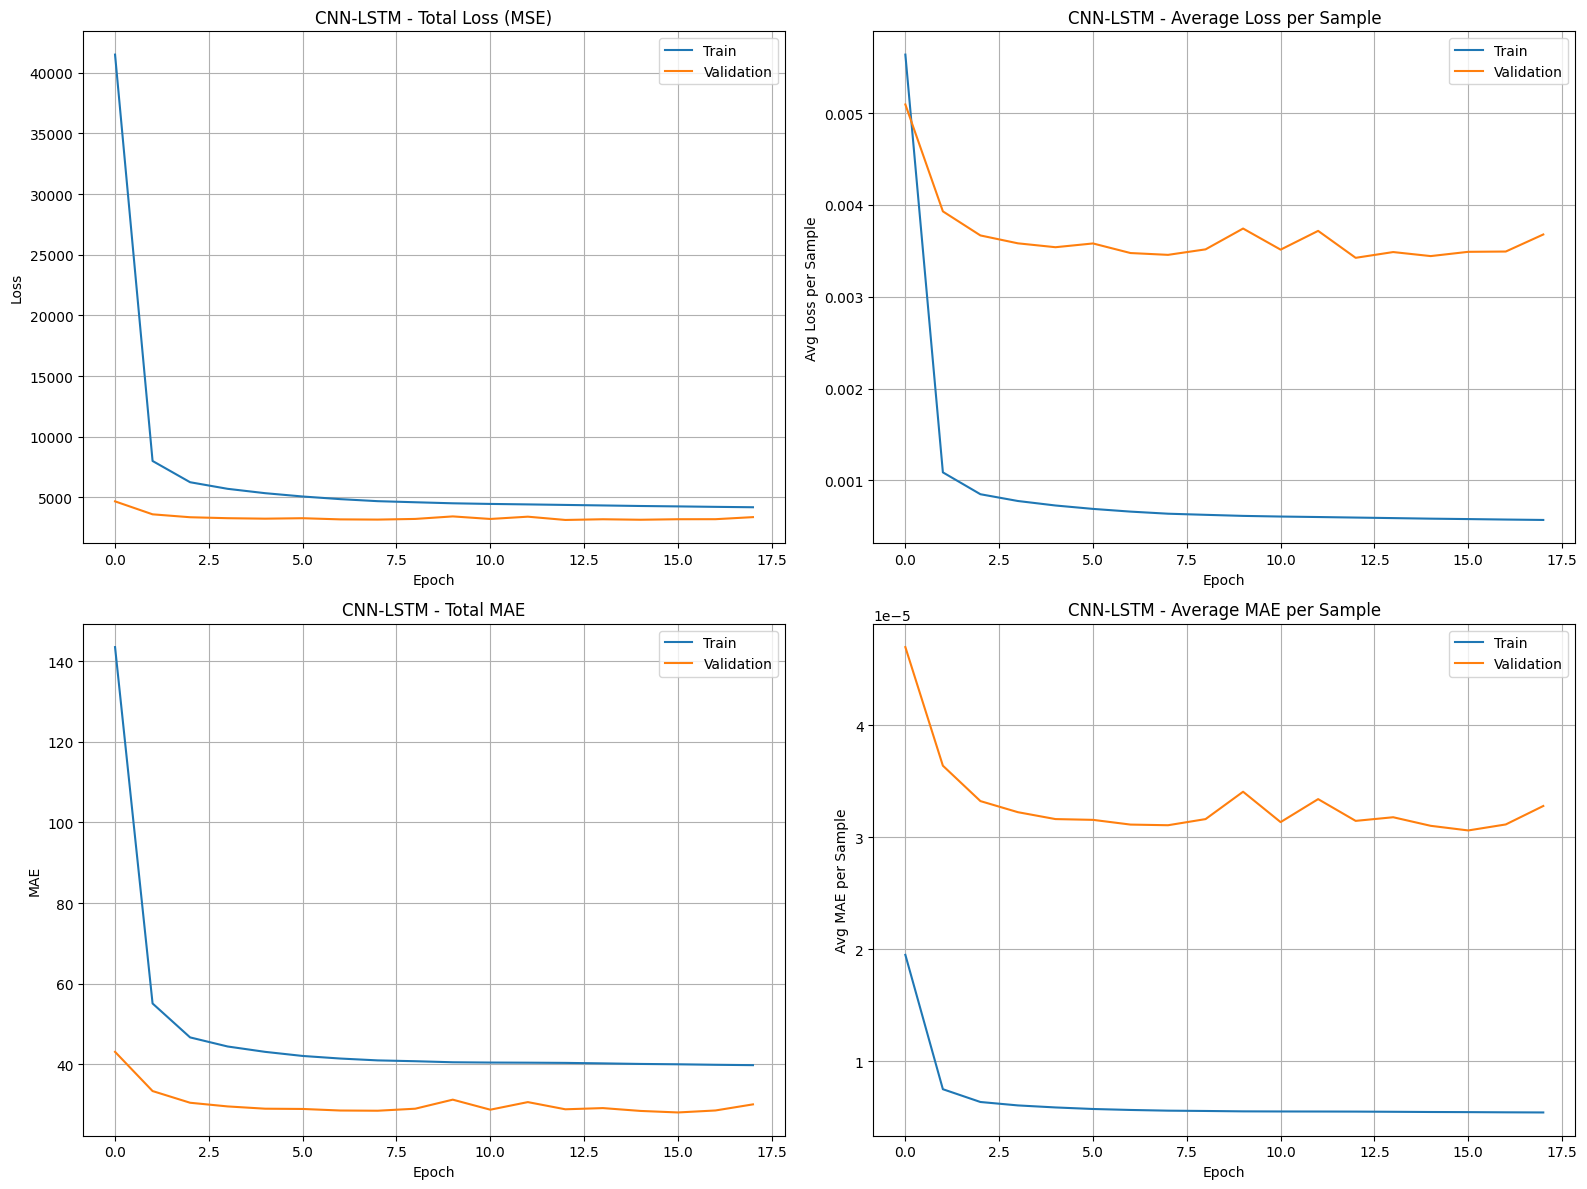


Evaluating CNN-LSTM model on test set...



CNN-LSTM - Test Evaluation Metrics:
  Overall:  MSE: 3274.12, RMSE: 57.22, MAE: 29.81, R²: 0.9646, MASE: 0.59
  Daytime:  MSE: 6549.21, RMSE: 80.93, MAE: 56.39, R²: 0.9204, MASE: 0.56
  Nighttime: MSE: 23.22, RMSE: 4.82, MAE: 3.42, R²: -7.9004, MASE: 33.74



CNN-LSTM - Test Timing Metrics:
  Inference Speed: 310191.31 samples/sec, 3.2238 μs/sample
  Total time: 2.9653 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0075s, max=0.0267s, std=0.0018s
Model saved to checkpoints/CNN-LSTM_best_20250507_203731.pt with metadata.
Best model saved to checkpoints/CNN-LSTM_best_20250507_203731.pt
Saved model checkpoint logged to wandb: checkpoints/CNN-LSTM_best_20250507_203731.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/timing_iterations,▁
test/timing_warmup_enabled,▁
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


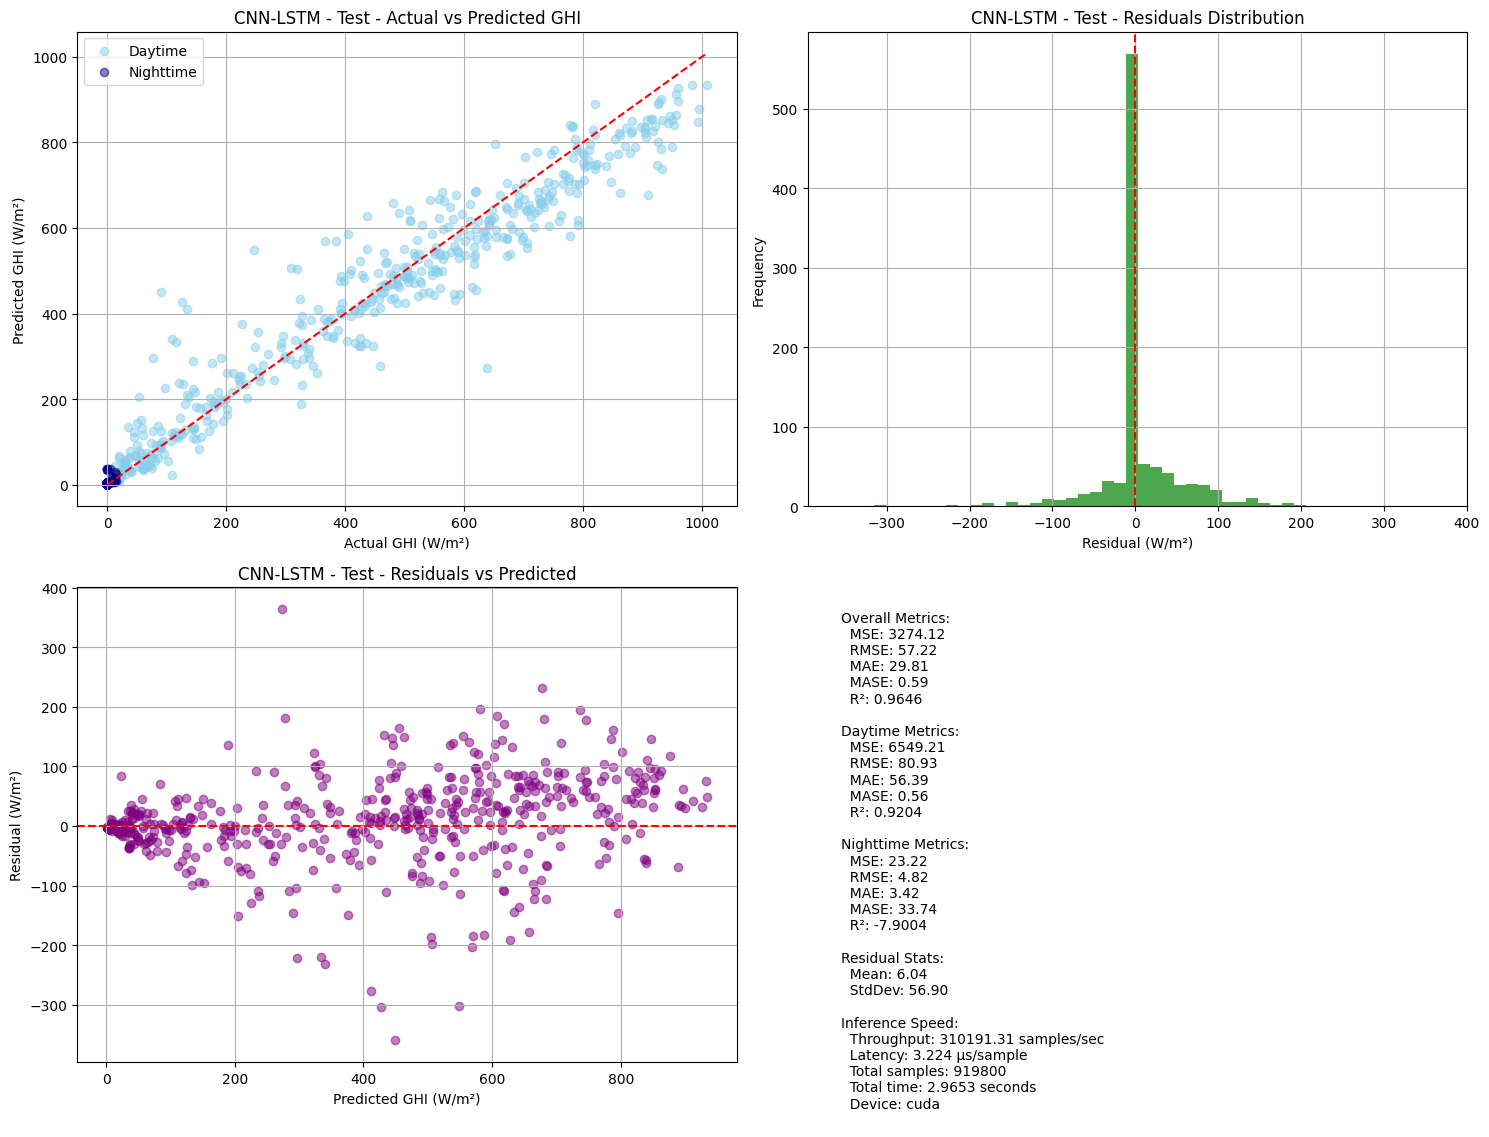

In [11]:
model_name = "CNN-LSTM"

# Train the LSTM model
cnn_lstm_history, cnn_lstm_val_metrics, cnn_lstm_test_metrics = run_experiment_pipeline(
    cnn_lstm_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.3 Multi-Layer Perceptron (MLP) Model

The MLP is a classic feedforward neural network with fully connected layers. While not specifically designed for sequential data,
with proper feature engineering, MLPs can still perform well on time series tasks. Here, we flatten the temporal features to use with the MLP.

For detailed model code: `models/mlp.py`

In [12]:
from models.mlp import MLPModel

# Create MLP model
mlp_model = MLPModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dims=[256, 512, 256, 128],
    dropout=0.2,
    lookback=LOOKBACK
).to(device)

# Print the model
print_model_info(mlp_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: MLPModel
Total parameters: 425,793
Trainable parameters: 425,793
Non-trainable parameters: 0

Model structure:
MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=456, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, mom

Training MLP model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for MLP


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation MLP (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4430.81, RMSE: 66.56, MAE: 39.99, R²: 0.9516, MASE: 0.85
  Daytime:  MSE: 8483.16, RMSE: 92.10, MAE: 65.72, R²: 0.8938, MASE: 0.69
  Nighttime: MSE: 408.06, RMSE: 20.20, MAE: 14.44, R²: -151.6785, MASE: 140.23
Epoch 1/30 | Train Loss: 47777.9531, Train MAE: 151.0471 | Val Loss: 4430.8110, Val MAE: 39.9855 | LR: 0.000100



Validation MLP (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3621.81, RMSE: 60.18, MAE: 32.72, R²: 0.9605, MASE: 0.69
  Daytime:  MSE: 7171.22, RMSE: 84.68, MAE: 58.80, R²: 0.9102, MASE: 0.62
  Nighttime: MSE: 98.32, RMSE: 9.92, MAE: 6.84, R²: -35.7857, MASE: 66.43
Epoch 2/30 | Train Loss: 9701.3340, Train MAE: 69.6546 | Val Loss: 3621.8059, Val MAE: 32.7234 | LR: 0.000100



Validation MLP (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3365.56, RMSE: 58.01, MAE: 30.67, R²: 0.9633, MASE: 0.65
  Daytime:  MSE: 6710.91, RMSE: 81.92, MAE: 56.85, R²: 0.9160, MASE: 0.60
  Nighttime: MSE: 44.64, RMSE: 6.68, MAE: 4.68, R²: -15.7004, MASE: 45.45
Epoch 3/30 | Train Loss: 6861.5566, Train MAE: 55.6277 | Val Loss: 3365.5576, Val MAE: 30.6681 | LR: 0.000100



Validation MLP (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3253.21, RMSE: 57.04, MAE: 29.11, R²: 0.9645, MASE: 0.62
  Daytime:  MSE: 6500.54, RMSE: 80.63, MAE: 54.79, R²: 0.9186, MASE: 0.58
  Nighttime: MSE: 29.59, RMSE: 5.44, MAE: 3.62, R²: -10.0712, MASE: 35.18
Epoch 4/30 | Train Loss: 5775.5298, Train MAE: 48.6327 | Val Loss: 3253.2073, Val MAE: 29.1143 | LR: 0.000100



Validation MLP (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3176.00, RMSE: 56.36, MAE: 28.61, R²: 0.9653, MASE: 0.61
  Daytime:  MSE: 6347.91, RMSE: 79.67, MAE: 54.07, R²: 0.9205, MASE: 0.57
  Nighttime: MSE: 27.27, RMSE: 5.22, MAE: 3.34, R²: -9.2028, MASE: 32.48
Epoch 5/30 | Train Loss: 5162.3076, Train MAE: 43.9932 | Val Loss: 3176.0046, Val MAE: 28.6145 | LR: 0.000100



Validation MLP (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3170.18, RMSE: 56.30, MAE: 27.45, R²: 0.9654, MASE: 0.58
  Daytime:  MSE: 6327.46, RMSE: 79.55, MAE: 51.02, R²: 0.9208, MASE: 0.54
  Nighttime: MSE: 35.95, RMSE: 6.00, MAE: 4.05, R²: -12.4504, MASE: 39.32
Epoch 6/30 | Train Loss: 4786.3838, Train MAE: 40.8251 | Val Loss: 3170.1763, Val MAE: 27.4470 | LR: 0.000100



Validation MLP (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3143.99, RMSE: 56.07, MAE: 30.16, R²: 0.9657, MASE: 0.64
  Daytime:  MSE: 6234.60, RMSE: 78.96, MAE: 52.55, R²: 0.9219, MASE: 0.55
  Nighttime: MSE: 75.95, RMSE: 8.71, MAE: 7.94, R²: -27.4152, MASE: 77.05
Epoch 7/30 | Train Loss: 4546.8765, Train MAE: 38.9176 | Val Loss: 3143.9878, Val MAE: 30.1630 | LR: 0.000100



Validation MLP (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3278.42, RMSE: 57.26, MAE: 31.96, R²: 0.9642, MASE: 0.68
  Daytime:  MSE: 6504.89, RMSE: 80.65, MAE: 56.05, R²: 0.9186, MASE: 0.59
  Nighttime: MSE: 75.52, RMSE: 8.69, MAE: 8.04, R²: -27.2579, MASE: 78.10
Epoch 8/30 | Train Loss: 4348.5425, Train MAE: 37.6832 | Val Loss: 3278.4243, Val MAE: 31.9568 | LR: 0.000100



Validation MLP (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3139.91, RMSE: 56.03, MAE: 30.29, R²: 0.9657, MASE: 0.64
  Daytime:  MSE: 6229.68, RMSE: 78.93, MAE: 52.78, R²: 0.9220, MASE: 0.56
  Nighttime: MSE: 72.70, RMSE: 8.53, MAE: 7.97, R²: -26.2012, MASE: 77.37
Epoch 9/30 | Train Loss: 4214.4600, Train MAE: 37.0809 | Val Loss: 3139.9060, Val MAE: 30.2921 | LR: 0.000100



Validation MLP (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3105.84, RMSE: 55.73, MAE: 29.01, R²: 0.9661, MASE: 0.61
  Daytime:  MSE: 6190.96, RMSE: 78.68, MAE: 52.61, R²: 0.9225, MASE: 0.56
  Nighttime: MSE: 43.26, RMSE: 6.58, MAE: 5.59, R²: -15.1855, MASE: 54.31
Epoch 10/30 | Train Loss: 4116.9390, Train MAE: 36.7834 | Val Loss: 3105.8433, Val MAE: 29.0134 | LR: 0.000100



Validation MLP (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3111.86, RMSE: 55.78, MAE: 28.89, R²: 0.9660, MASE: 0.61
  Daytime:  MSE: 6216.53, RMSE: 78.84, MAE: 53.19, R²: 0.9222, MASE: 0.56
  Nighttime: MSE: 29.86, RMSE: 5.46, MAE: 4.77, R²: -10.1731, MASE: 46.28
Epoch 11/30 | Train Loss: 4035.5781, Train MAE: 36.6006 | Val Loss: 3111.8577, Val MAE: 28.8889 | LR: 0.000100



Validation MLP (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3045.92, RMSE: 55.19, MAE: 26.81, R²: 0.9668, MASE: 0.57
  Daytime:  MSE: 6099.02, RMSE: 78.10, MAE: 51.23, R²: 0.9236, MASE: 0.54
  Nighttime: MSE: 15.12, RMSE: 3.89, MAE: 2.58, R²: -4.6579, MASE: 25.03
Epoch 12/30 | Train Loss: 3960.3289, Train MAE: 36.4236 | Val Loss: 3045.9238, Val MAE: 26.8129 | LR: 0.000100



Validation MLP (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3141.22, RMSE: 56.05, MAE: 27.86, R²: 0.9657, MASE: 0.59
  Daytime:  MSE: 6290.47, RMSE: 79.31, MAE: 54.07, R²: 0.9212, MASE: 0.57
  Nighttime: MSE: 14.97, RMSE: 3.87, MAE: 1.84, R²: -4.5999, MASE: 17.84
Epoch 13/30 | Train Loss: 3889.0178, Train MAE: 36.2672 | Val Loss: 3141.2200, Val MAE: 27.8554 | LR: 0.000100



Validation MLP (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3059.77, RMSE: 55.32, MAE: 26.29, R²: 0.9666, MASE: 0.56
  Daytime:  MSE: 6126.07, RMSE: 78.27, MAE: 50.45, R²: 0.9233, MASE: 0.53
  Nighttime: MSE: 15.86, RMSE: 3.98, MAE: 2.31, R²: -4.9339, MASE: 22.43
Epoch 14/30 | Train Loss: 3840.5283, Train MAE: 36.2067 | Val Loss: 3059.7666, Val MAE: 26.2923 | LR: 0.000100



Validation MLP (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3076.15, RMSE: 55.46, MAE: 26.81, R²: 0.9664, MASE: 0.57
  Daytime:  MSE: 6164.47, RMSE: 78.51, MAE: 52.25, R²: 0.9228, MASE: 0.55
  Nighttime: MSE: 10.38, RMSE: 3.22, MAE: 1.56, R²: -2.8844, MASE: 15.12
Epoch 15/30 | Train Loss: 3796.1372, Train MAE: 36.1684 | Val Loss: 3076.1467, Val MAE: 26.8087 | LR: 0.000100



Validation MLP (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3076.76, RMSE: 55.47, MAE: 27.10, R²: 0.9664, MASE: 0.57
  Daytime:  MSE: 6164.62, RMSE: 78.52, MAE: 52.29, R²: 0.9228, MASE: 0.55
  Nighttime: MSE: 11.46, RMSE: 3.39, MAE: 2.10, R²: -3.2880, MASE: 20.36
Epoch 16/30 | Train Loss: 3749.4277, Train MAE: 36.0793 | Val Loss: 3076.7639, Val MAE: 27.0998 | LR: 0.000100



Validation MLP (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3211.53, RMSE: 56.67, MAE: 27.88, R²: 0.9650, MASE: 0.59
  Daytime:  MSE: 6432.35, RMSE: 80.20, MAE: 54.84, R²: 0.9195, MASE: 0.58
  Nighttime: MSE: 14.24, RMSE: 3.77, MAE: 1.11, R²: -4.3267, MASE: 10.74
Epoch 17/30 | Train Loss: 3720.6013, Train MAE: 36.0772 | Val Loss: 3211.5344, Val MAE: 27.8767 | LR: 0.000100
Early stopping at epoch 17
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


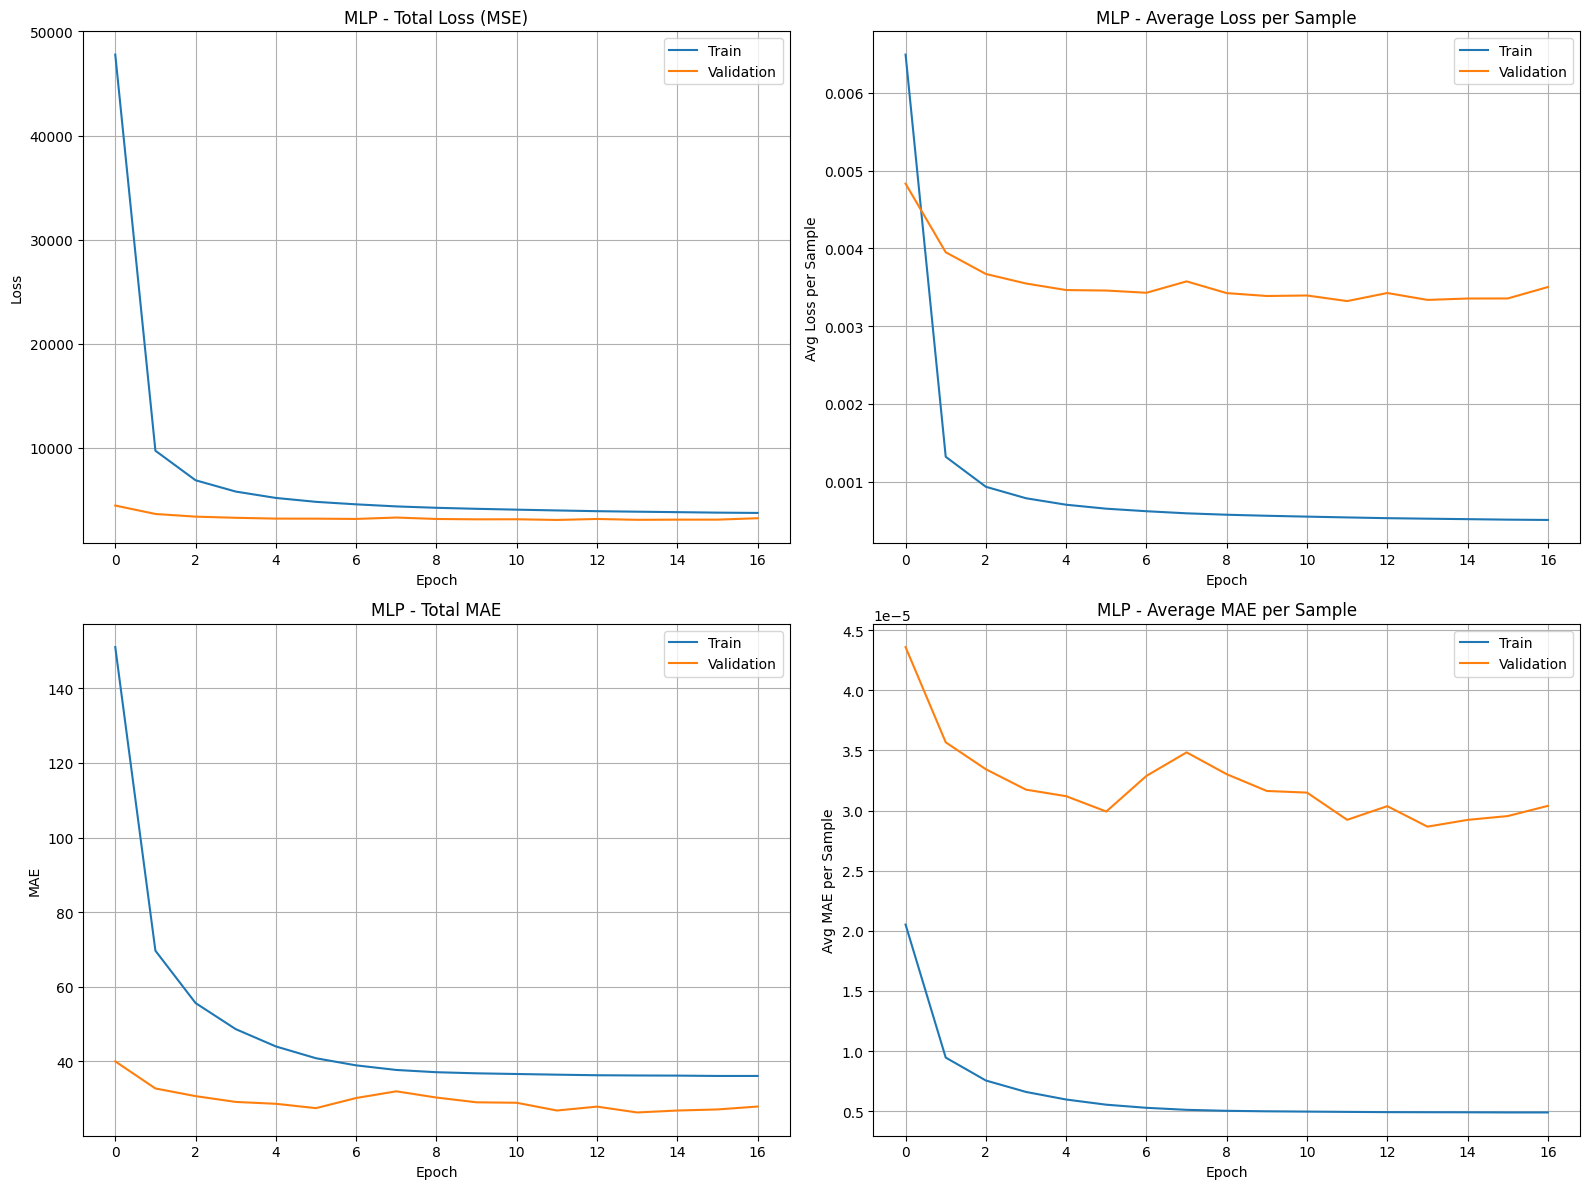


Evaluating MLP model on test set...



MLP - Test Evaluation Metrics:
  Overall:  MSE: 3165.89, RMSE: 56.27, MAE: 27.84, R²: 0.9658, MASE: 0.55
  Daytime:  MSE: 6343.43, RMSE: 79.65, MAE: 54.85, R²: 0.9229, MASE: 0.54
  Nighttime: MSE: 11.81, RMSE: 3.44, MAE: 1.02, R²: -3.5264, MASE: 10.10



MLP - Test Timing Metrics:
  Inference Speed: 5642588.94 samples/sec, 0.1772 μs/sample
  Total time: 0.1630 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0005s, max=0.0015s, std=0.0001s
Model saved to checkpoints/MLP_best_20250507_210619.pt with metadata.
Best model saved to checkpoints/MLP_best_20250507_210619.pt
Saved model checkpoint logged to wandb: checkpoints/MLP_best_20250507_210619.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/timing_iterations,▁
test/timing_warmup_enabled,▁
train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


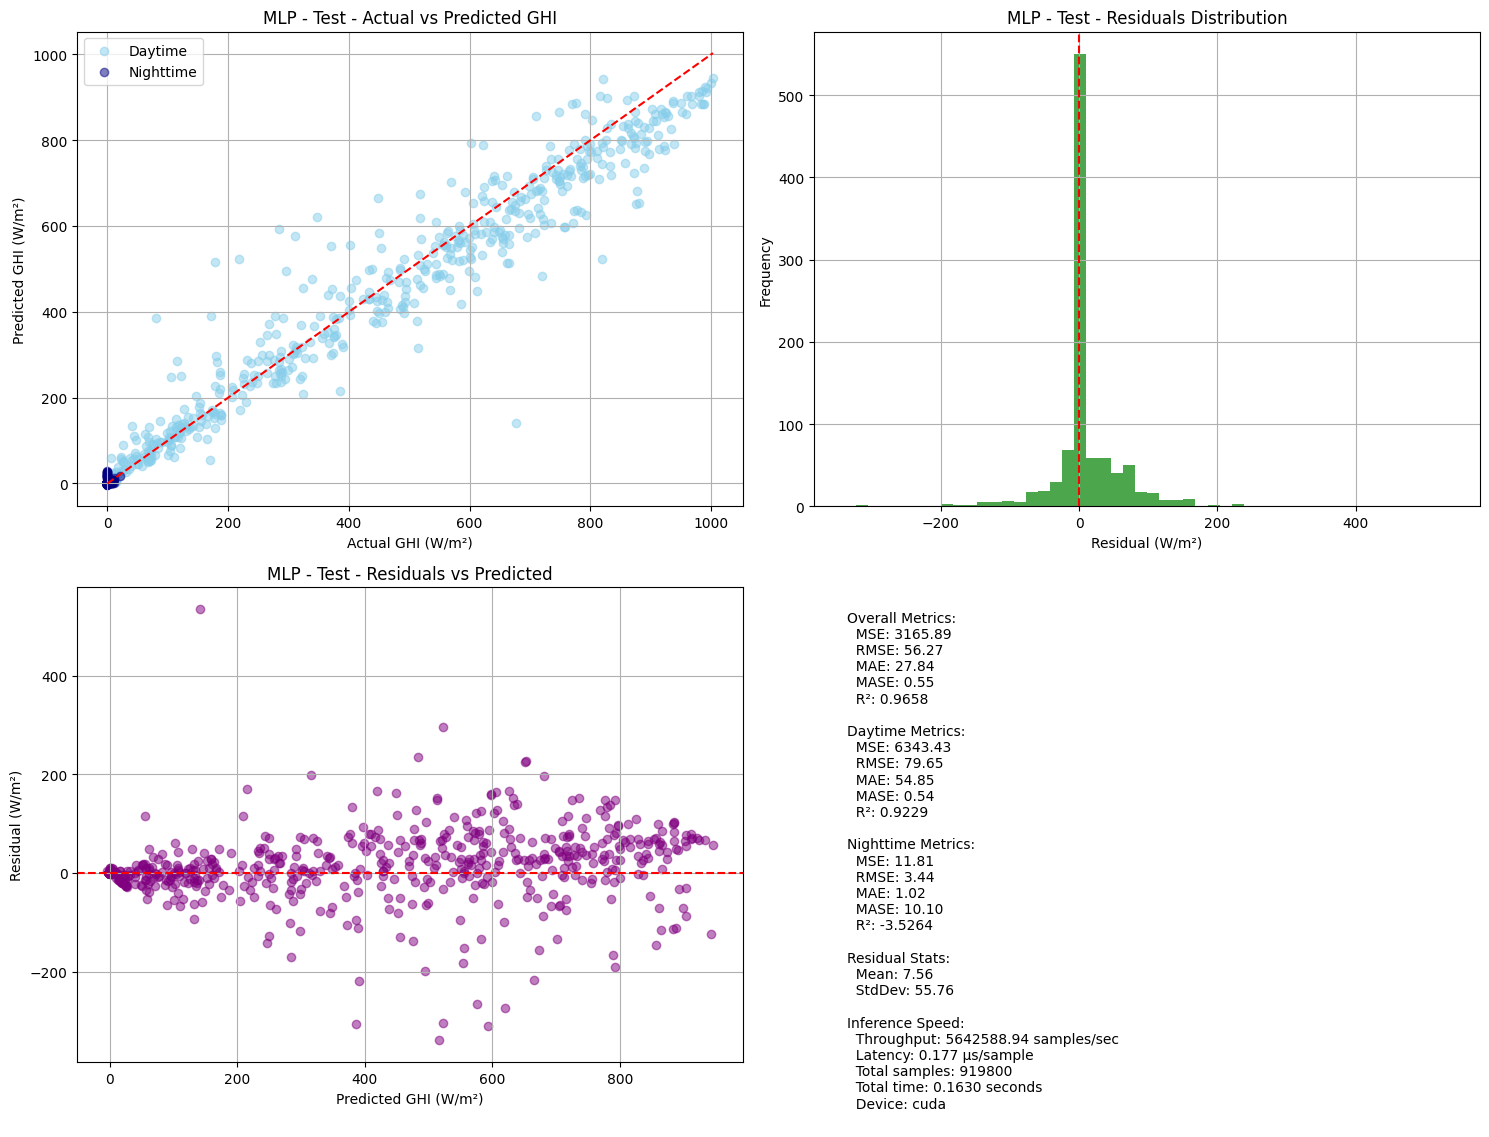

In [13]:
model_name = "MLP"

# Train the MLP model
mlp_history, mlp_val_metrics, mlp_test_metrics = run_experiment_pipeline(
    mlp_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.4 1D CNN Model

The 1D Convolutional Neural Network applies filters across the time dimension to extract patterns from sequential data.
This approach is effective for capturing local patterns and can be computationally more efficient than recurrent networks.

In [14]:
from models.cnn1d import CNN1DModel

# Create MLP model
cnn1d_model = CNN1DModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    num_filters=[64, 128, 256],
    kernel_sizes=[3, 3, 3],
    dropout=0.2
).to(device)

# Print the model
print_model_info(cnn1d_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: CNN1DModel
Total parameters: 176,097
Trainable parameters: 176,097
Non-trainable parameters: 0

Model structure:
CNN1DModel(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 25

Training 1D-CNN model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for 1D-CNN


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation 1D-CNN (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 8180.75, RMSE: 90.45, MAE: 59.18, R²: 0.9107, MASE: 1.25
  Daytime:  MSE: 15946.47, RMSE: 126.28, MAE: 101.86, R²: 0.8003, MASE: 1.07
  Nighttime: MSE: 471.74, RMSE: 21.72, MAE: 16.81, R²: -175.5054, MASE: 163.20
Epoch 1/30 | Train Loss: 38210.6797, Train MAE: 141.1656 | Val Loss: 8180.7461, Val MAE: 59.1753 | LR: 0.000100



Validation 1D-CNN (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 6527.41, RMSE: 80.79, MAE: 51.47, R²: 0.9288, MASE: 1.09
  Daytime:  MSE: 12785.03, RMSE: 113.07, MAE: 90.54, R²: 0.8399, MASE: 0.96
  Nighttime: MSE: 315.50, RMSE: 17.76, MAE: 12.70, R²: -117.0459, MASE: 123.29
Epoch 2/30 | Train Loss: 10883.5947, Train MAE: 74.6063 | Val Loss: 6527.4121, Val MAE: 51.4738 | LR: 0.000100



Validation 1D-CNN (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 5501.15, RMSE: 74.17, MAE: 44.73, R²: 0.9400, MASE: 0.95
  Daytime:  MSE: 10928.96, RMSE: 104.54, MAE: 82.85, R²: 0.8632, MASE: 0.87
  Nighttime: MSE: 112.98, RMSE: 10.63, MAE: 6.87, R²: -41.2734, MASE: 66.75
Epoch 3/30 | Train Loss: 7316.4443, Train MAE: 57.4745 | Val Loss: 5501.1523, Val MAE: 44.7251 | LR: 0.000100



Validation 1D-CNN (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 4983.34, RMSE: 70.59, MAE: 41.82, R²: 0.9456, MASE: 0.89
  Daytime:  MSE: 9922.70, RMSE: 99.61, MAE: 78.11, R²: 0.8758, MASE: 0.82
  Nighttime: MSE: 80.05, RMSE: 8.95, MAE: 5.80, R²: -28.9514, MASE: 56.31
Epoch 4/30 | Train Loss: 5978.9385, Train MAE: 49.5586 | Val Loss: 4983.3423, Val MAE: 41.8218 | LR: 0.000100



Validation 1D-CNN (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 4818.08, RMSE: 69.41, MAE: 40.98, R²: 0.9474, MASE: 0.87
  Daytime:  MSE: 9589.51, RMSE: 97.93, MAE: 76.12, R²: 0.8799, MASE: 0.80
  Nighttime: MSE: 81.50, RMSE: 9.03, MAE: 6.11, R²: -29.4934, MASE: 59.31
Epoch 5/30 | Train Loss: 5334.9595, Train MAE: 45.3161 | Val Loss: 4818.0811, Val MAE: 40.9849 | LR: 0.000100



Validation 1D-CNN (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 4646.25, RMSE: 68.16, MAE: 40.97, R²: 0.9493, MASE: 0.87
  Daytime:  MSE: 9255.49, RMSE: 96.21, MAE: 75.29, R²: 0.8841, MASE: 0.79
  Nighttime: MSE: 70.68, RMSE: 8.41, MAE: 6.91, R²: -25.4437, MASE: 67.07
Epoch 6/30 | Train Loss: 4973.7148, Train MAE: 42.8557 | Val Loss: 4646.2534, Val MAE: 40.9716 | LR: 0.000100



Validation 1D-CNN (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 4522.67, RMSE: 67.25, MAE: 38.60, R²: 0.9506, MASE: 0.82
  Daytime:  MSE: 9041.56, RMSE: 95.09, MAE: 73.72, R²: 0.8868, MASE: 0.78
  Nighttime: MSE: 36.80, RMSE: 6.07, MAE: 3.75, R²: -12.7675, MASE: 36.42
Epoch 7/30 | Train Loss: 4736.0664, Train MAE: 41.3663 | Val Loss: 4522.6738, Val MAE: 38.6048 | LR: 0.000100



Validation 1D-CNN (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 4204.78, RMSE: 64.84, MAE: 36.02, R²: 0.9541, MASE: 0.76
  Daytime:  MSE: 8402.24, RMSE: 91.66, MAE: 70.06, R²: 0.8948, MASE: 0.74
  Nighttime: MSE: 37.97, RMSE: 6.16, MAE: 2.22, R²: -13.2058, MASE: 21.58
Epoch 8/30 | Train Loss: 4562.7168, Train MAE: 40.3867 | Val Loss: 4204.7759, Val MAE: 36.0158 | LR: 0.000100



Validation 1D-CNN (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 4150.66, RMSE: 64.43, MAE: 35.69, R²: 0.9547, MASE: 0.76
  Daytime:  MSE: 8312.66, RMSE: 91.17, MAE: 69.51, R²: 0.8959, MASE: 0.73
  Nighttime: MSE: 19.05, RMSE: 4.36, MAE: 2.10, R²: -6.1287, MASE: 20.43
Epoch 9/30 | Train Loss: 4424.2017, Train MAE: 39.6430 | Val Loss: 4150.6582, Val MAE: 35.6853 | LR: 0.000100



Validation 1D-CNN (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 4011.81, RMSE: 63.34, MAE: 35.02, R²: 0.9562, MASE: 0.74
  Daytime:  MSE: 8029.97, RMSE: 89.61, MAE: 68.08, R²: 0.8995, MASE: 0.72
  Nighttime: MSE: 23.01, RMSE: 4.80, MAE: 2.20, R²: -7.6081, MASE: 21.32
Epoch 10/30 | Train Loss: 4325.6880, Train MAE: 39.1027 | Val Loss: 4011.8125, Val MAE: 35.0156 | LR: 0.000100



Validation 1D-CNN (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3951.91, RMSE: 62.86, MAE: 35.13, R²: 0.9569, MASE: 0.74
  Daytime:  MSE: 7904.73, RMSE: 88.91, MAE: 67.86, R²: 0.9010, MASE: 0.72
  Nighttime: MSE: 27.97, RMSE: 5.29, MAE: 2.63, R²: -9.4636, MASE: 25.57
Epoch 11/30 | Train Loss: 4235.2261, Train MAE: 38.6297 | Val Loss: 3951.9136, Val MAE: 35.1267 | LR: 0.000100



Validation 1D-CNN (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3735.60, RMSE: 61.12, MAE: 33.21, R²: 0.9592, MASE: 0.70
  Daytime:  MSE: 7480.32, RMSE: 86.49, MAE: 65.22, R²: 0.9063, MASE: 0.69
  Nighttime: MSE: 18.24, RMSE: 4.27, MAE: 1.44, R²: -5.8236, MASE: 13.98
Epoch 12/30 | Train Loss: 4161.9741, Train MAE: 38.2713 | Val Loss: 3735.6016, Val MAE: 33.2114 | LR: 0.000100



Validation 1D-CNN (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3934.79, RMSE: 62.73, MAE: 34.45, R²: 0.9571, MASE: 0.73
  Daytime:  MSE: 7886.31, RMSE: 88.80, MAE: 67.56, R²: 0.9013, MASE: 0.71
  Nighttime: MSE: 12.13, RMSE: 3.48, MAE: 1.58, R²: -3.5389, MASE: 15.37
Epoch 13/30 | Train Loss: 4103.7153, Train MAE: 37.9468 | Val Loss: 3934.7908, Val MAE: 34.4527 | LR: 0.000100



Validation 1D-CNN (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3693.51, RMSE: 60.77, MAE: 33.61, R²: 0.9597, MASE: 0.71
  Daytime:  MSE: 7391.20, RMSE: 85.97, MAE: 64.53, R²: 0.9075, MASE: 0.68
  Nighttime: MSE: 22.83, RMSE: 4.78, MAE: 2.91, R²: -7.5419, MASE: 28.29
Epoch 14/30 | Train Loss: 4045.6721, Train MAE: 37.6678 | Val Loss: 3693.5100, Val MAE: 33.6088 | LR: 0.000100



Validation 1D-CNN (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3678.63, RMSE: 60.65, MAE: 34.03, R²: 0.9599, MASE: 0.72
  Daytime:  MSE: 7360.37, RMSE: 85.79, MAE: 64.43, R²: 0.9078, MASE: 0.68
  Nighttime: MSE: 23.78, RMSE: 4.88, MAE: 3.84, R²: -7.8960, MASE: 37.33
Epoch 15/30 | Train Loss: 4005.1616, Train MAE: 37.4599 | Val Loss: 3678.6294, Val MAE: 34.0259 | LR: 0.000100



Validation 1D-CNN (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3771.41, RMSE: 61.41, MAE: 35.19, R²: 0.9588, MASE: 0.74
  Daytime:  MSE: 7538.44, RMSE: 86.82, MAE: 65.76, R²: 0.9056, MASE: 0.69
  Nighttime: MSE: 31.89, RMSE: 5.65, MAE: 4.84, R²: -10.9302, MASE: 46.97
Epoch 16/30 | Train Loss: 3964.5610, Train MAE: 37.2652 | Val Loss: 3771.4058, Val MAE: 35.1873 | LR: 0.000100



Validation 1D-CNN (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3673.46, RMSE: 60.61, MAE: 33.93, R²: 0.9599, MASE: 0.72
  Daytime:  MSE: 7356.57, RMSE: 85.77, MAE: 64.50, R²: 0.9079, MASE: 0.68
  Nighttime: MSE: 17.26, RMSE: 4.15, MAE: 3.59, R²: -5.4561, MASE: 34.85
Epoch 17/30 | Train Loss: 3929.6345, Train MAE: 37.0928 | Val Loss: 3673.4617, Val MAE: 33.9326 | LR: 0.000100



Validation 1D-CNN (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 3654.79, RMSE: 60.45, MAE: 32.88, R²: 0.9601, MASE: 0.70
  Daytime:  MSE: 7328.98, RMSE: 85.61, MAE: 64.19, R²: 0.9082, MASE: 0.68
  Nighttime: MSE: 7.44, RMSE: 2.73, MAE: 1.79, R²: -1.7821, MASE: 17.36
Epoch 18/30 | Train Loss: 3903.8296, Train MAE: 36.9785 | Val Loss: 3654.7942, Val MAE: 32.8765 | LR: 0.000100



Validation 1D-CNN (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 3589.05, RMSE: 59.91, MAE: 32.68, R²: 0.9608, MASE: 0.69
  Daytime:  MSE: 7191.32, RMSE: 84.80, MAE: 62.69, R²: 0.9100, MASE: 0.66
  Nighttime: MSE: 13.10, RMSE: 3.62, MAE: 2.88, R²: -3.8996, MASE: 27.97
Epoch 19/30 | Train Loss: 3863.5139, Train MAE: 36.8101 | Val Loss: 3589.0515, Val MAE: 32.6761 | LR: 0.000100



Validation 1D-CNN (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 3681.17, RMSE: 60.67, MAE: 33.20, R²: 0.9598, MASE: 0.70
  Daytime:  MSE: 7379.93, RMSE: 85.91, MAE: 64.44, R²: 0.9076, MASE: 0.68
  Nighttime: MSE: 9.42, RMSE: 3.07, MAE: 2.18, R²: -2.5250, MASE: 21.19
Epoch 20/30 | Train Loss: 3837.5164, Train MAE: 36.7027 | Val Loss: 3681.1714, Val MAE: 33.1984 | LR: 0.000100



Validation 1D-CNN (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 3522.46, RMSE: 59.35, MAE: 32.19, R²: 0.9616, MASE: 0.68
  Daytime:  MSE: 7060.61, RMSE: 84.03, MAE: 61.97, R²: 0.9116, MASE: 0.65
  Nighttime: MSE: 10.14, RMSE: 3.18, MAE: 2.64, R²: -2.7938, MASE: 25.60
Epoch 21/30 | Train Loss: 3819.9561, Train MAE: 36.6146 | Val Loss: 3522.4573, Val MAE: 32.1947 | LR: 0.000100



Validation 1D-CNN (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 3592.09, RMSE: 59.93, MAE: 32.90, R²: 0.9608, MASE: 0.70
  Daytime:  MSE: 7197.70, RMSE: 84.84, MAE: 63.07, R²: 0.9099, MASE: 0.67
  Nighttime: MSE: 12.82, RMSE: 3.58, MAE: 2.96, R²: -3.7955, MASE: 28.73
Epoch 22/30 | Train Loss: 3795.5088, Train MAE: 36.5110 | Val Loss: 3592.0901, Val MAE: 32.9020 | LR: 0.000100



Validation 1D-CNN (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 3610.14, RMSE: 60.08, MAE: 31.88, R²: 0.9606, MASE: 0.67
  Daytime:  MSE: 7242.83, RMSE: 85.10, MAE: 62.89, R²: 0.9093, MASE: 0.66
  Nighttime: MSE: 3.99, RMSE: 2.00, MAE: 1.10, R²: -0.4920, MASE: 10.68
Epoch 23/30 | Train Loss: 3767.6270, Train MAE: 36.3885 | Val Loss: 3610.1416, Val MAE: 31.8811 | LR: 0.000100



Validation 1D-CNN (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 3610.99, RMSE: 60.09, MAE: 31.94, R²: 0.9606, MASE: 0.68
  Daytime:  MSE: 7243.53, RMSE: 85.11, MAE: 62.87, R²: 0.9093, MASE: 0.66
  Nighttime: MSE: 4.97, RMSE: 2.23, MAE: 1.23, R²: -0.8596, MASE: 11.93
Epoch 24/30 | Train Loss: 3743.4858, Train MAE: 36.3068 | Val Loss: 3610.9854, Val MAE: 31.9354 | LR: 0.000100



Validation 1D-CNN (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 3633.85, RMSE: 60.28, MAE: 33.20, R²: 0.9603, MASE: 0.70
  Daytime:  MSE: 7280.58, RMSE: 85.33, MAE: 63.35, R²: 0.9088, MASE: 0.67
  Nighttime: MSE: 13.77, RMSE: 3.71, MAE: 3.27, R²: -4.1516, MASE: 31.77
Epoch 25/30 | Train Loss: 3726.2383, Train MAE: 36.2383 | Val Loss: 3633.8547, Val MAE: 33.1992 | LR: 0.000100



Validation 1D-CNN (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 3625.40, RMSE: 60.21, MAE: 32.88, R²: 0.9604, MASE: 0.70
  Daytime:  MSE: 7267.06, RMSE: 85.25, MAE: 63.27, R²: 0.9090, MASE: 0.67
  Nighttime: MSE: 10.34, RMSE: 3.22, MAE: 2.72, R²: -2.8683, MASE: 26.46
Epoch 26/30 | Train Loss: 3704.5784, Train MAE: 36.1430 | Val Loss: 3625.3982, Val MAE: 32.8843 | LR: 0.000100
Early stopping at epoch 26
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


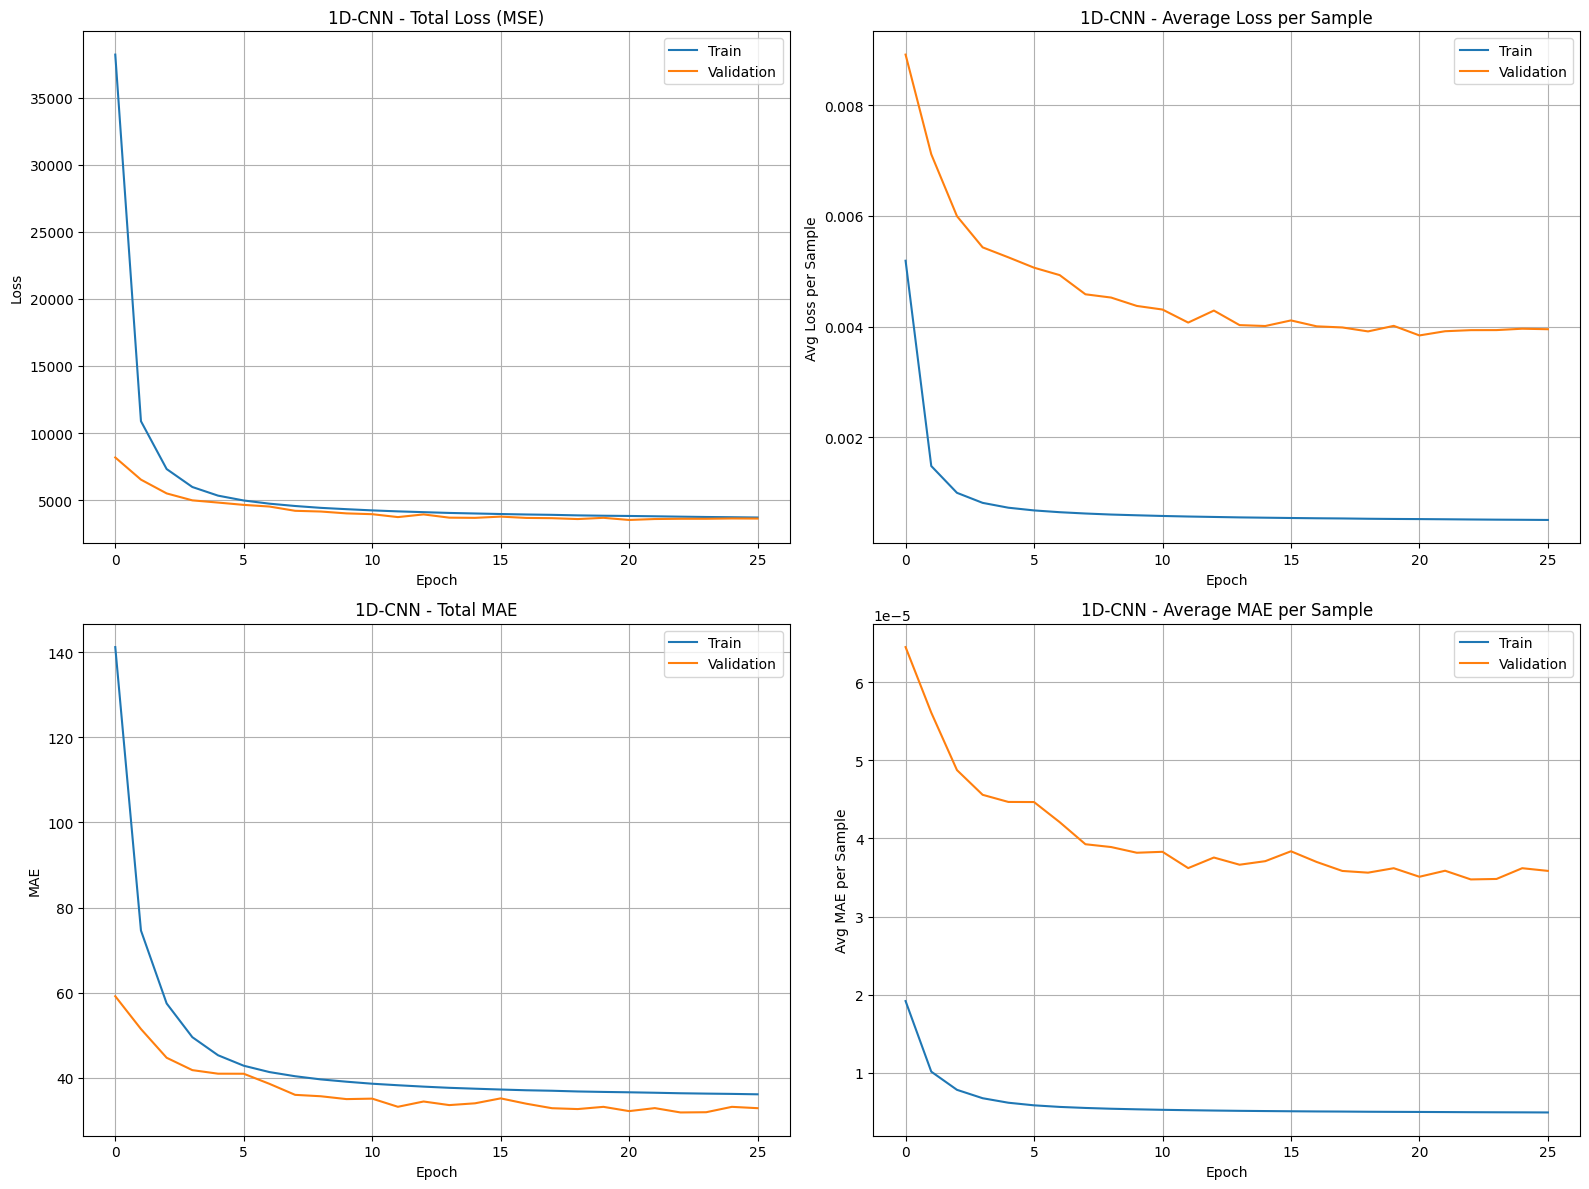


Evaluating 1D-CNN model on test set...



1D-CNN - Test Evaluation Metrics:
  Overall:  MSE: 3549.03, RMSE: 59.57, MAE: 32.44, R²: 0.9617, MASE: 0.64
  Daytime:  MSE: 7115.13, RMSE: 84.35, MAE: 62.48, R²: 0.9136, MASE: 0.62
  Nighttime: MSE: 9.26, RMSE: 3.04, MAE: 2.62, R²: -2.5485, MASE: 25.85



1D-CNN - Test Timing Metrics:
  Inference Speed: 996542.81 samples/sec, 1.0035 μs/sample
  Total time: 0.9230 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0025s, max=0.0084s, std=0.0005s
Model saved to checkpoints/1D-CNN_best_20250507_215240.pt with metadata.
Best model saved to checkpoints/1D-CNN_best_20250507_215240.pt
Saved model checkpoint logged to wandb: checkpoints/1D-CNN_best_20250507_215240.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/timing_iterations,▁
test/timing_warmup_enabled,▁
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


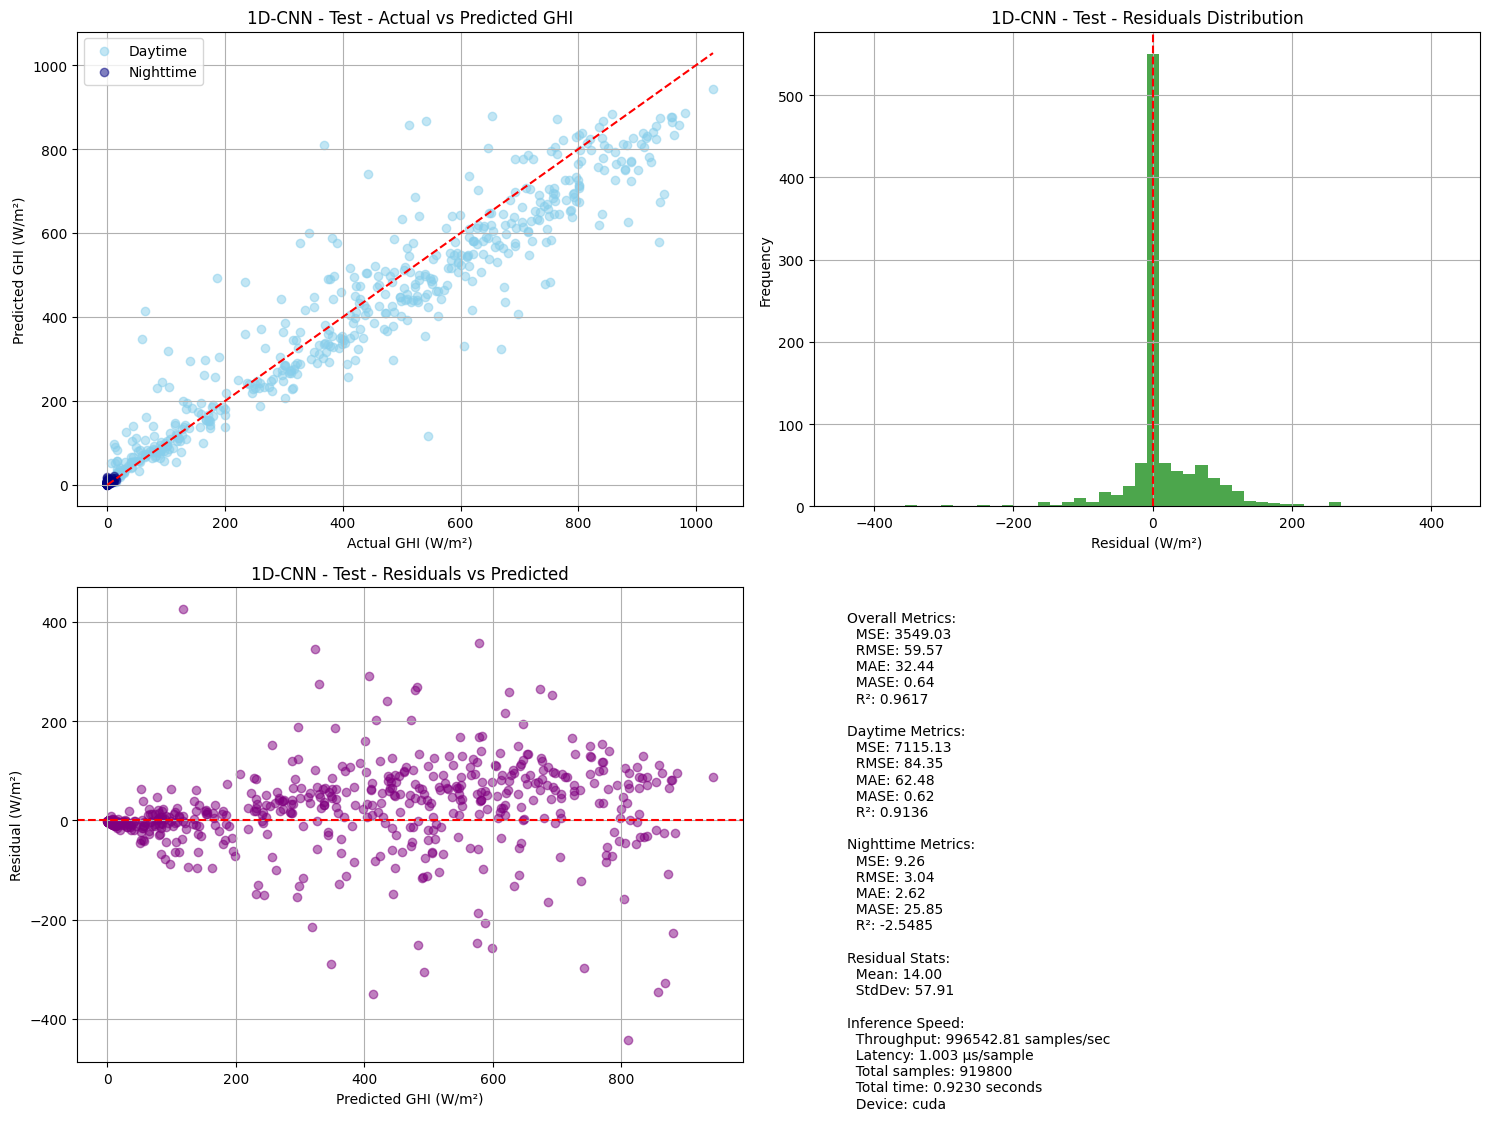

In [15]:
model_name = "1D-CNN"

# Train the MLP model
cnn1d_history, cnn1d_val_metrics, cnn1d_test_metrics = run_experiment_pipeline(
    cnn1d_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.5 Temporal Convolutional Networks (TCN) Model

TCNs are specialized convolutional architectures for sequence modeling that combine the best of CNNs and RNNs. The key features include:

- **Causal Convolutions**: Each output only depends on current and past inputs.
- **Dilated Convolutions**: Captures larger effective history with fewer parameters.
- **Residual Connections**: Helps with training deep networks and information flow.

TCNs can capture long-range patterns in time series data efficiently, making them suitable for solar radiation forecasting where both short-term weather fluctuations and longer-term patterns matter.

For detailed model code: `models/tcn.py`

In [16]:
from models.tcn import TCNModel

# Create TCN model
tcn_model = TCNModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    num_channels=[32, 64, 64, 32],    # Number of channels in each layer
    kernel_size=3,                    # Size of the convolutional kernel
    dropout=0.1,                      # Dropout rate
).to(device)

# Print the model
print_model_info(tcn_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TCNModel
Total parameters: 82,273
Trainable parameters: 82,273
Non-trainable parameters: 0

Model structure:
TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU

/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training TCN model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for TCN


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation TCN (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4689.80, RMSE: 68.48, MAE: 38.77, R²: 0.9488, MASE: 0.82
  Daytime:  MSE: 9161.95, RMSE: 95.72, MAE: 65.88, R²: 0.8853, MASE: 0.70
  Nighttime: MSE: 250.31, RMSE: 15.82, MAE: 11.85, R²: -92.6544, MASE: 115.08
Epoch 1/30 | Train Loss: 37252.3633, Train MAE: 129.3561 | Val Loss: 4689.7979, Val MAE: 38.7659 | LR: 0.000100



Validation TCN (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3666.33, RMSE: 60.55, MAE: 32.01, R²: 0.9600, MASE: 0.68
  Daytime:  MSE: 7235.31, RMSE: 85.06, MAE: 56.05, R²: 0.9094, MASE: 0.59
  Nighttime: MSE: 123.42, RMSE: 11.11, MAE: 8.14, R²: -45.1765, MASE: 79.06
Epoch 2/30 | Train Loss: 9192.3486, Train MAE: 66.7267 | Val Loss: 3666.3320, Val MAE: 32.0057 | LR: 0.000100



Validation TCN (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3352.45, RMSE: 57.90, MAE: 30.96, R²: 0.9634, MASE: 0.66
  Daytime:  MSE: 6589.20, RMSE: 81.17, MAE: 54.06, R²: 0.9175, MASE: 0.57
  Nighttime: MSE: 139.34, RMSE: 11.80, MAE: 8.03, R²: -51.1351, MASE: 77.93
Epoch 3/30 | Train Loss: 5740.3027, Train MAE: 49.3170 | Val Loss: 3352.4517, Val MAE: 30.9605 | LR: 0.000100



Validation TCN (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3254.25, RMSE: 57.05, MAE: 29.78, R²: 0.9645, MASE: 0.63
  Daytime:  MSE: 6420.32, RMSE: 80.13, MAE: 51.04, R²: 0.9196, MASE: 0.54
  Nighttime: MSE: 111.31, RMSE: 10.55, MAE: 8.66, R²: -40.6473, MASE: 84.11
Epoch 4/30 | Train Loss: 4572.1245, Train MAE: 40.9124 | Val Loss: 3254.2542, Val MAE: 29.7752 | LR: 0.000100



Validation TCN (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3149.92, RMSE: 56.12, MAE: 28.67, R²: 0.9656, MASE: 0.61
  Daytime:  MSE: 6284.68, RMSE: 79.28, MAE: 52.50, R²: 0.9213, MASE: 0.55
  Nighttime: MSE: 38.05, RMSE: 6.17, MAE: 5.01, R²: -13.2354, MASE: 48.66
Epoch 5/30 | Train Loss: 4077.8208, Train MAE: 36.3624 | Val Loss: 3149.9172, Val MAE: 28.6678 | LR: 0.000100



Validation TCN (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3071.23, RMSE: 55.42, MAE: 27.30, R²: 0.9665, MASE: 0.58
  Daytime:  MSE: 6145.96, RMSE: 78.40, MAE: 51.09, R²: 0.9230, MASE: 0.54
  Nighttime: MSE: 18.95, RMSE: 4.35, MAE: 3.67, R²: -6.0910, MASE: 35.67
Epoch 6/30 | Train Loss: 3840.1401, Train MAE: 34.0001 | Val Loss: 3071.2261, Val MAE: 27.2970 | LR: 0.000100



Validation TCN (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3049.18, RMSE: 55.22, MAE: 26.64, R²: 0.9667, MASE: 0.56
  Daytime:  MSE: 6112.34, RMSE: 78.18, MAE: 51.09, R²: 0.9235, MASE: 0.54
  Nighttime: MSE: 8.39, RMSE: 2.90, MAE: 2.36, R²: -2.1380, MASE: 22.91
Epoch 7/30 | Train Loss: 3708.2063, Train MAE: 32.8292 | Val Loss: 3049.1758, Val MAE: 26.6361 | LR: 0.000100



Validation TCN (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3012.11, RMSE: 54.88, MAE: 25.98, R²: 0.9671, MASE: 0.55
  Daytime:  MSE: 6041.70, RMSE: 77.73, MAE: 50.55, R²: 0.9244, MASE: 0.53
  Nighttime: MSE: 4.65, RMSE: 2.16, MAE: 1.58, R²: -0.7385, MASE: 15.38
Epoch 8/30 | Train Loss: 3615.2817, Train MAE: 32.1343 | Val Loss: 3012.1099, Val MAE: 25.9790 | LR: 0.000100



Validation TCN (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2999.12, RMSE: 54.76, MAE: 26.18, R²: 0.9673, MASE: 0.55
  Daytime:  MSE: 6013.77, RMSE: 77.55, MAE: 50.47, R²: 0.9247, MASE: 0.53
  Nighttime: MSE: 6.49, RMSE: 2.55, MAE: 2.08, R²: -1.4266, MASE: 20.17
Epoch 9/30 | Train Loss: 3551.4690, Train MAE: 31.7063 | Val Loss: 2999.1221, Val MAE: 26.1844 | LR: 0.000100



Validation TCN (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2992.24, RMSE: 54.70, MAE: 25.40, R²: 0.9673, MASE: 0.54
  Daytime:  MSE: 6001.80, RMSE: 77.47, MAE: 49.28, R²: 0.9249, MASE: 0.52
  Nighttime: MSE: 4.66, RMSE: 2.16, MAE: 1.69, R²: -0.7451, MASE: 16.43
Epoch 10/30 | Train Loss: 3506.5867, Train MAE: 31.4236 | Val Loss: 2992.2400, Val MAE: 25.3969 | LR: 0.000100



Validation TCN (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2995.86, RMSE: 54.73, MAE: 25.74, R²: 0.9673, MASE: 0.54
  Daytime:  MSE: 6011.03, RMSE: 77.53, MAE: 50.53, R²: 0.9247, MASE: 0.53
  Nighttime: MSE: 2.71, RMSE: 1.65, MAE: 1.13, R²: -0.0130, MASE: 10.96
Epoch 11/30 | Train Loss: 3463.9089, Train MAE: 31.1802 | Val Loss: 2995.8572, Val MAE: 25.7397 | LR: 0.000100



Validation TCN (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2990.48, RMSE: 54.69, MAE: 24.97, R²: 0.9674, MASE: 0.53
  Daytime:  MSE: 5998.44, RMSE: 77.45, MAE: 48.35, R²: 0.9249, MASE: 0.51
  Nighttime: MSE: 4.49, RMSE: 2.12, MAE: 1.76, R²: -0.6810, MASE: 17.05
Epoch 12/30 | Train Loss: 3429.0061, Train MAE: 30.9965 | Val Loss: 2990.4805, Val MAE: 24.9701 | LR: 0.000100



Validation TCN (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2966.32, RMSE: 54.46, MAE: 25.45, R²: 0.9676, MASE: 0.54
  Daytime:  MSE: 5952.08, RMSE: 77.15, MAE: 49.97, R²: 0.9255, MASE: 0.53
  Nighttime: MSE: 2.35, RMSE: 1.53, MAE: 1.12, R²: 0.1189, MASE: 10.90
Epoch 13/30 | Train Loss: 3405.4546, Train MAE: 30.8761 | Val Loss: 2966.3157, Val MAE: 25.4546 | LR: 0.000100



Validation TCN (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2964.67, RMSE: 54.45, MAE: 25.11, R²: 0.9676, MASE: 0.53
  Daytime:  MSE: 5948.62, RMSE: 77.13, MAE: 49.22, R²: 0.9255, MASE: 0.52
  Nighttime: MSE: 2.50, RMSE: 1.58, MAE: 1.17, R²: 0.0636, MASE: 11.34
Epoch 14/30 | Train Loss: 3382.8418, Train MAE: 30.7658 | Val Loss: 2964.6653, Val MAE: 25.1076 | LR: 0.000100



Validation TCN (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3005.45, RMSE: 54.82, MAE: 24.84, R²: 0.9672, MASE: 0.53
  Daytime:  MSE: 6028.18, RMSE: 77.64, MAE: 47.87, R²: 0.9245, MASE: 0.51
  Nighttime: MSE: 4.80, RMSE: 2.19, MAE: 1.97, R²: -0.7972, MASE: 19.14
Epoch 15/30 | Train Loss: 3360.1357, Train MAE: 30.6450 | Val Loss: 3005.4543, Val MAE: 24.8374 | LR: 0.000100



Validation TCN (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2961.45, RMSE: 54.42, MAE: 25.80, R²: 0.9677, MASE: 0.55
  Daytime:  MSE: 5941.37, RMSE: 77.08, MAE: 50.18, R²: 0.9256, MASE: 0.53
  Nighttime: MSE: 3.29, RMSE: 1.81, MAE: 1.59, R²: -0.2305, MASE: 15.43
Epoch 16/30 | Train Loss: 3344.3906, Train MAE: 30.5514 | Val Loss: 2961.4492, Val MAE: 25.7964 | LR: 0.000100



Validation TCN (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2963.77, RMSE: 54.44, MAE: 25.18, R²: 0.9677, MASE: 0.53
  Daytime:  MSE: 5945.73, RMSE: 77.11, MAE: 48.86, R²: 0.9256, MASE: 0.52
  Nighttime: MSE: 3.58, RMSE: 1.89, MAE: 1.68, R²: -0.3384, MASE: 16.30
Epoch 17/30 | Train Loss: 3326.4651, Train MAE: 30.4911 | Val Loss: 2963.7651, Val MAE: 25.1831 | LR: 0.000100



Validation TCN (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2960.98, RMSE: 54.41, MAE: 25.16, R²: 0.9677, MASE: 0.53
  Daytime:  MSE: 5942.60, RMSE: 77.09, MAE: 49.69, R²: 0.9256, MASE: 0.52
  Nighttime: MSE: 1.13, RMSE: 1.06, MAE: 0.81, R²: 0.5761, MASE: 7.86
Epoch 18/30 | Train Loss: 3311.1301, Train MAE: 30.4173 | Val Loss: 2960.9788, Val MAE: 25.1590 | LR: 0.000100



Validation TCN (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2969.11, RMSE: 54.49, MAE: 25.41, R²: 0.9676, MASE: 0.54
  Daytime:  MSE: 5955.93, RMSE: 77.17, MAE: 49.13, R²: 0.9254, MASE: 0.52
  Nighttime: MSE: 4.10, RMSE: 2.03, MAE: 1.87, R²: -0.5344, MASE: 18.13
Epoch 19/30 | Train Loss: 3300.4434, Train MAE: 30.3832 | Val Loss: 2969.1072, Val MAE: 25.4116 | LR: 0.000100



Validation TCN (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2945.93, RMSE: 54.28, MAE: 24.73, R²: 0.9679, MASE: 0.52
  Daytime:  MSE: 5912.62, RMSE: 76.89, MAE: 48.98, R²: 0.9260, MASE: 0.52
  Nighttime: MSE: 0.90, RMSE: 0.95, MAE: 0.65, R²: 0.6634, MASE: 6.28
Epoch 20/30 | Train Loss: 3288.8616, Train MAE: 30.3498 | Val Loss: 2945.9270, Val MAE: 24.7255 | LR: 0.000100



Validation TCN (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2960.09, RMSE: 54.41, MAE: 25.12, R²: 0.9677, MASE: 0.53
  Daytime:  MSE: 5940.73, RMSE: 77.08, MAE: 49.57, R²: 0.9256, MASE: 0.52
  Nighttime: MSE: 1.22, RMSE: 1.10, MAE: 0.85, R²: 0.5437, MASE: 8.29
Epoch 21/30 | Train Loss: 3278.0437, Train MAE: 30.3249 | Val Loss: 2960.0881, Val MAE: 25.1206 | LR: 0.000100



Validation TCN (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 3003.11, RMSE: 54.80, MAE: 25.85, R²: 0.9672, MASE: 0.55
  Daytime:  MSE: 6027.60, RMSE: 77.64, MAE: 51.38, R²: 0.9245, MASE: 0.54
  Nighttime: MSE: 0.71, RMSE: 0.85, MAE: 0.50, R²: 0.7325, MASE: 4.86
Epoch 22/30 | Train Loss: 3269.3613, Train MAE: 30.2932 | Val Loss: 3003.1150, Val MAE: 25.8478 | LR: 0.000100



Validation TCN (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2972.72, RMSE: 54.52, MAE: 25.54, R²: 0.9676, MASE: 0.54
  Daytime:  MSE: 5965.68, RMSE: 77.24, MAE: 50.24, R²: 0.9253, MASE: 0.53
  Nighttime: MSE: 1.61, RMSE: 1.27, MAE: 1.01, R²: 0.3962, MASE: 9.84
Epoch 23/30 | Train Loss: 3260.5627, Train MAE: 30.2869 | Val Loss: 2972.7168, Val MAE: 25.5381 | LR: 0.000100



Validation TCN (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2967.63, RMSE: 54.48, MAE: 24.74, R²: 0.9676, MASE: 0.52
  Daytime:  MSE: 5956.34, RMSE: 77.18, MAE: 49.15, R²: 0.9254, MASE: 0.52
  Nighttime: MSE: 0.75, RMSE: 0.86, MAE: 0.50, R²: 0.7201, MASE: 4.86
Epoch 24/30 | Train Loss: 3249.0945, Train MAE: 30.2494 | Val Loss: 2967.6313, Val MAE: 24.7357 | LR: 0.000100



Validation TCN (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2989.22, RMSE: 54.67, MAE: 25.56, R²: 0.9674, MASE: 0.54
  Daytime:  MSE: 5999.83, RMSE: 77.46, MAE: 50.88, R²: 0.9249, MASE: 0.54
  Nighttime: MSE: 0.61, RMSE: 0.78, MAE: 0.43, R²: 0.7734, MASE: 4.22
Epoch 25/30 | Train Loss: 3242.3538, Train MAE: 30.2415 | Val Loss: 2989.2234, Val MAE: 25.5647 | LR: 0.000100
Early stopping at epoch 25
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


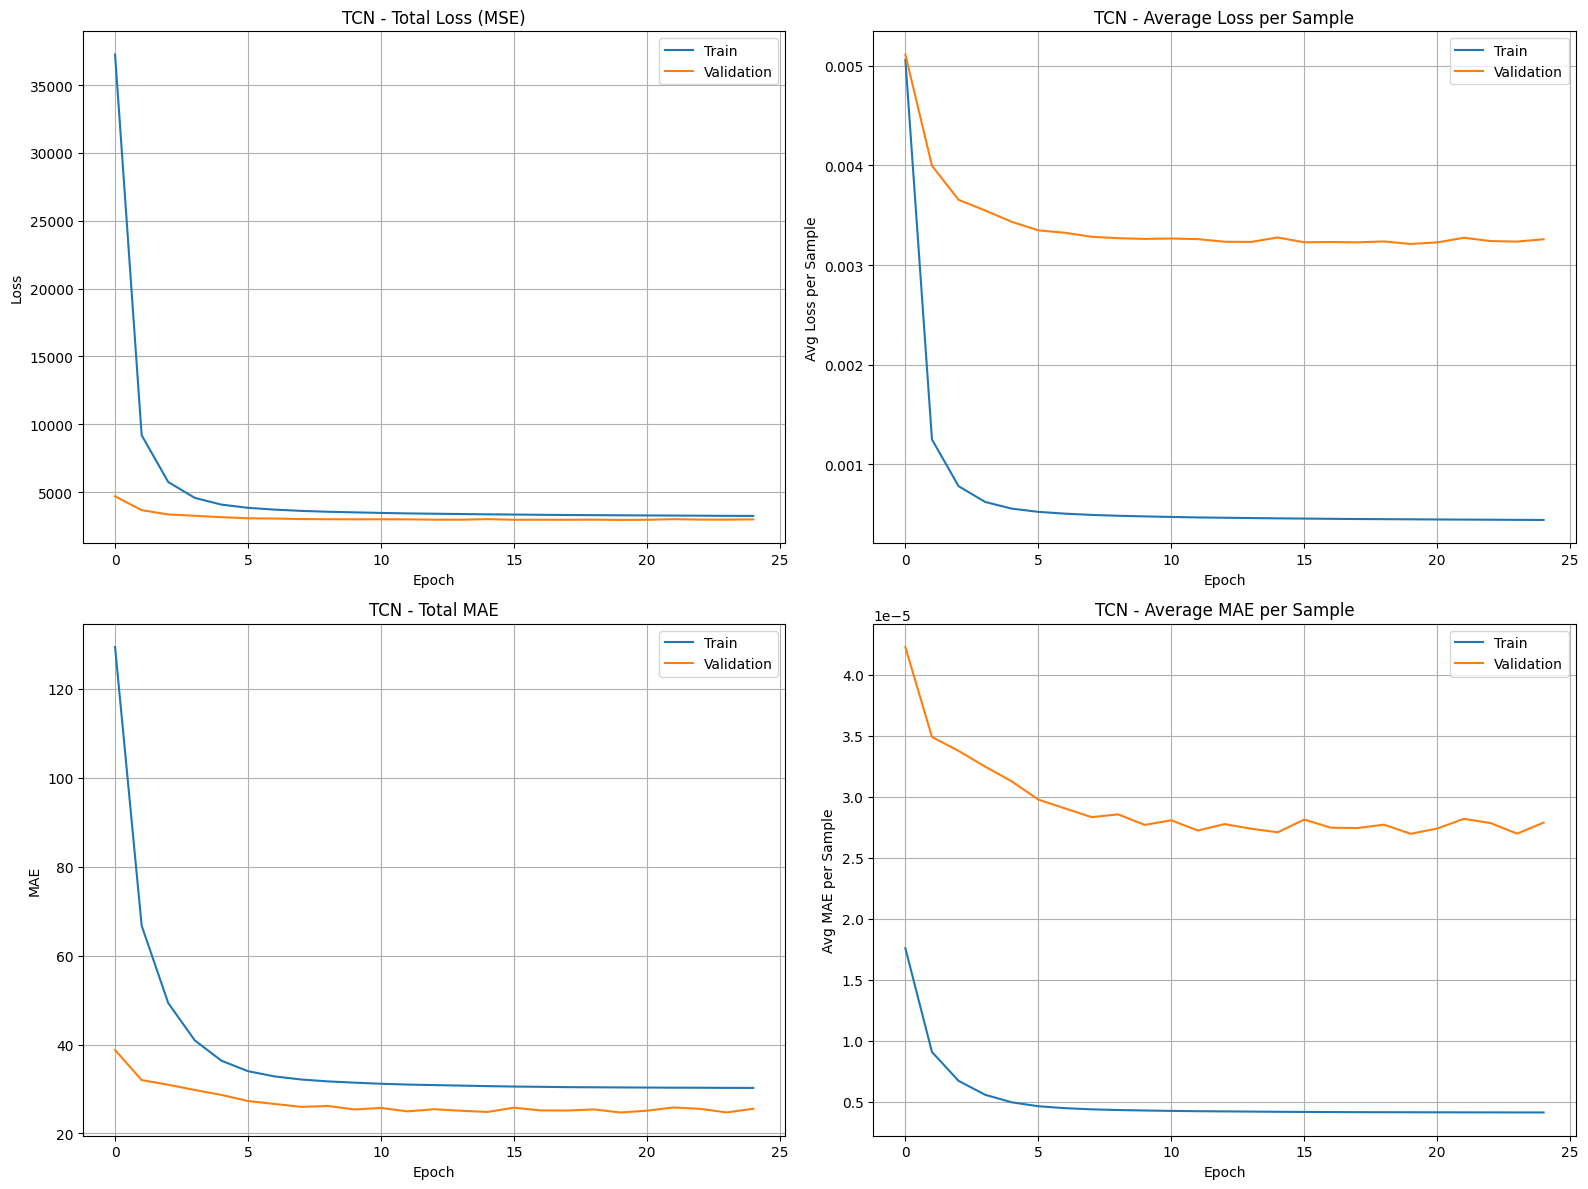


Evaluating TCN model on test set...



TCN - Test Evaluation Metrics:
  Overall:  MSE: 2856.48, RMSE: 53.45, MAE: 25.32, R²: 0.9691, MASE: 0.50
  Daytime:  MSE: 5733.53, RMSE: 75.72, MAE: 50.39, R²: 0.9303, MASE: 0.50
  Nighttime: MSE: 0.67, RMSE: 0.82, MAE: 0.44, R²: 0.7435, MASE: 4.36



TCN - Test Timing Metrics:
  Inference Speed: 644131.57 samples/sec, 1.5525 μs/sample
  Total time: 1.4280 sec for 919800 samples (averaged over 3 iterations)
  Batch time variation: min=0.0037s, max=0.0130s, std=0.0008s
Model saved to checkpoints/TCN_best_20250507_224035.pt with metadata.
Best model saved to checkpoints/TCN_best_20250507_224035.pt
Saved model checkpoint logged to wandb: checkpoints/TCN_best_20250507_224035.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/timing_iterations,▁
test/timing_warmup_enabled,▁
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


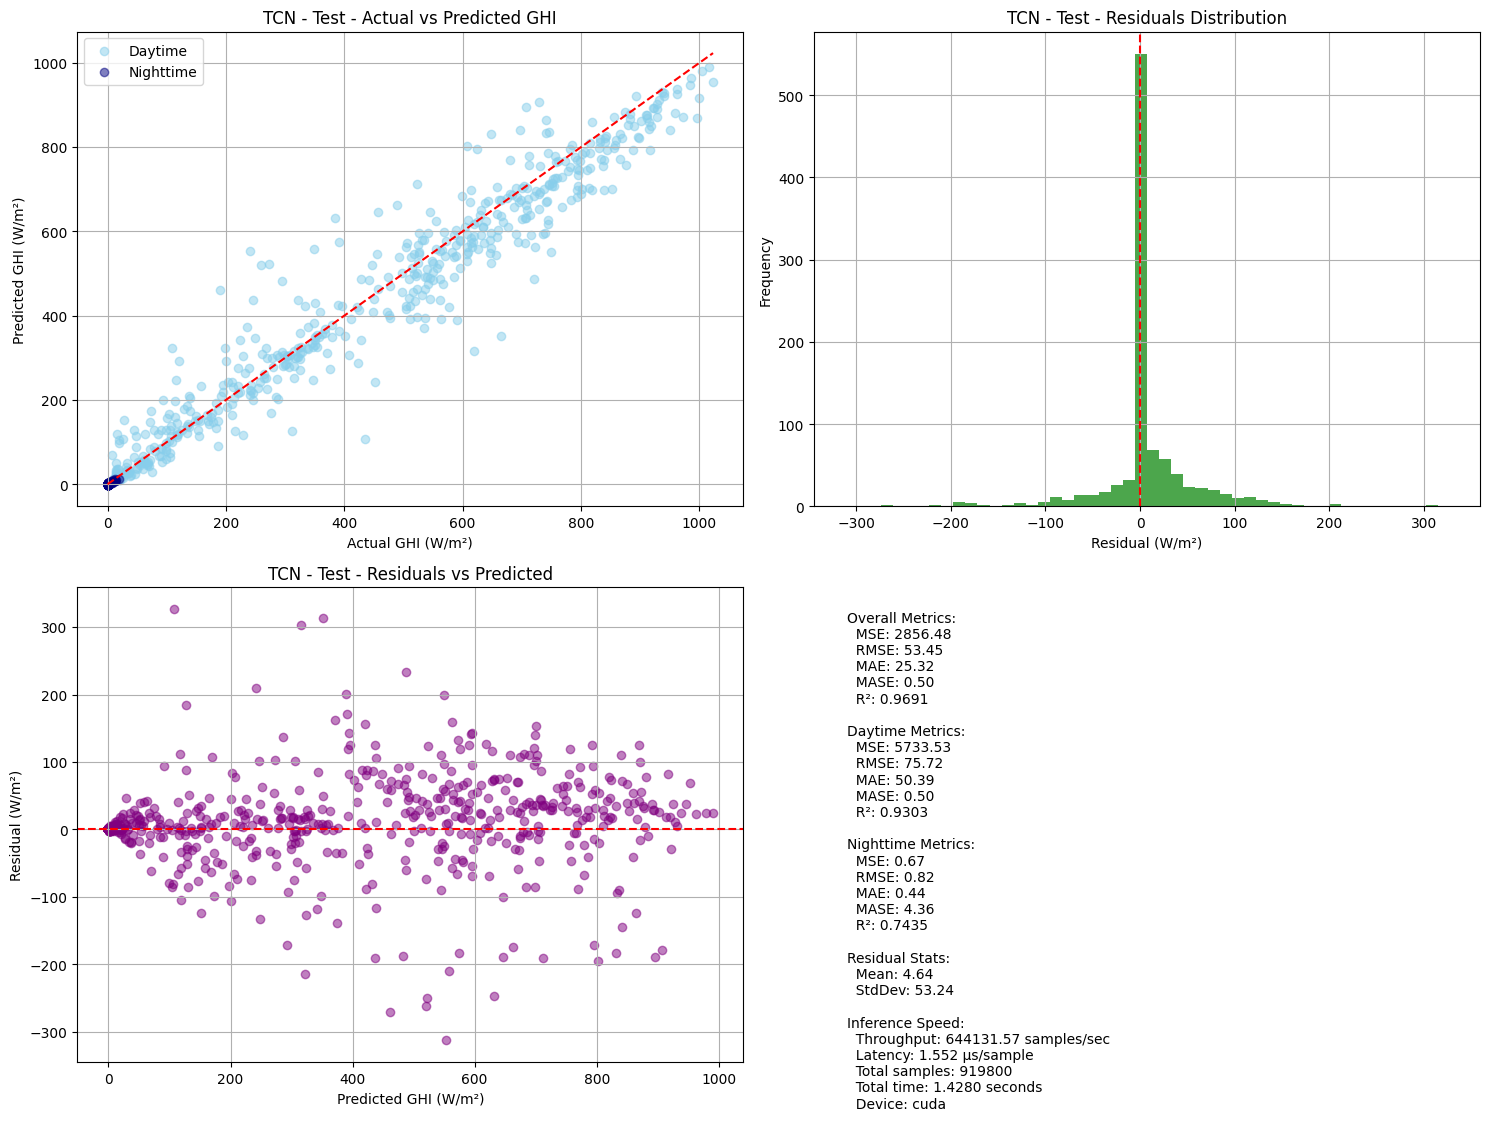

In [17]:
model_name = "TCN"

# Train the TCN model
tcn_history, tcn_val_metrics, tcn_test_metrics = run_experiment_pipeline(
    tcn_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

## 4. Model Comparison

After training all models, we compare their performance to determine which architecture works best for GHI forecasting.

## 4.1 Compare Models' Performance

This section compares the overall performance metrics (MSE, RMSE, MAE, MASE, R²) and inference speed of all trained models on the test dataset.
These metrics help us understand which model provides the most accurate predictions across the entire test set.


Model Comparison - Test Set:
                      LSTM       CNN-LSTM             MLP         1D-CNN  \
MSE            2859.217529       3274.125     3165.890137    3549.029297   
RMSE             53.471652       57.21997       56.266243       59.57373   
MAE              26.867414      29.809776       27.836973      32.442547   
MASE              0.534102       0.592593        0.553376        0.64493   
R²                0.969111       0.964628        0.965798       0.961658   
Samples/sec  215547.279473  310191.313966  5642588.944316  996542.806981   
μs/sample         4.639353       3.223817        0.177224       1.003469   

                       TCN  
MSE            2856.478516  
RMSE             53.446034  
MAE              25.324776  
MASE              0.503435  
R²                 0.96914  
Samples/sec  644131.568137  
μs/sample         1.552478  


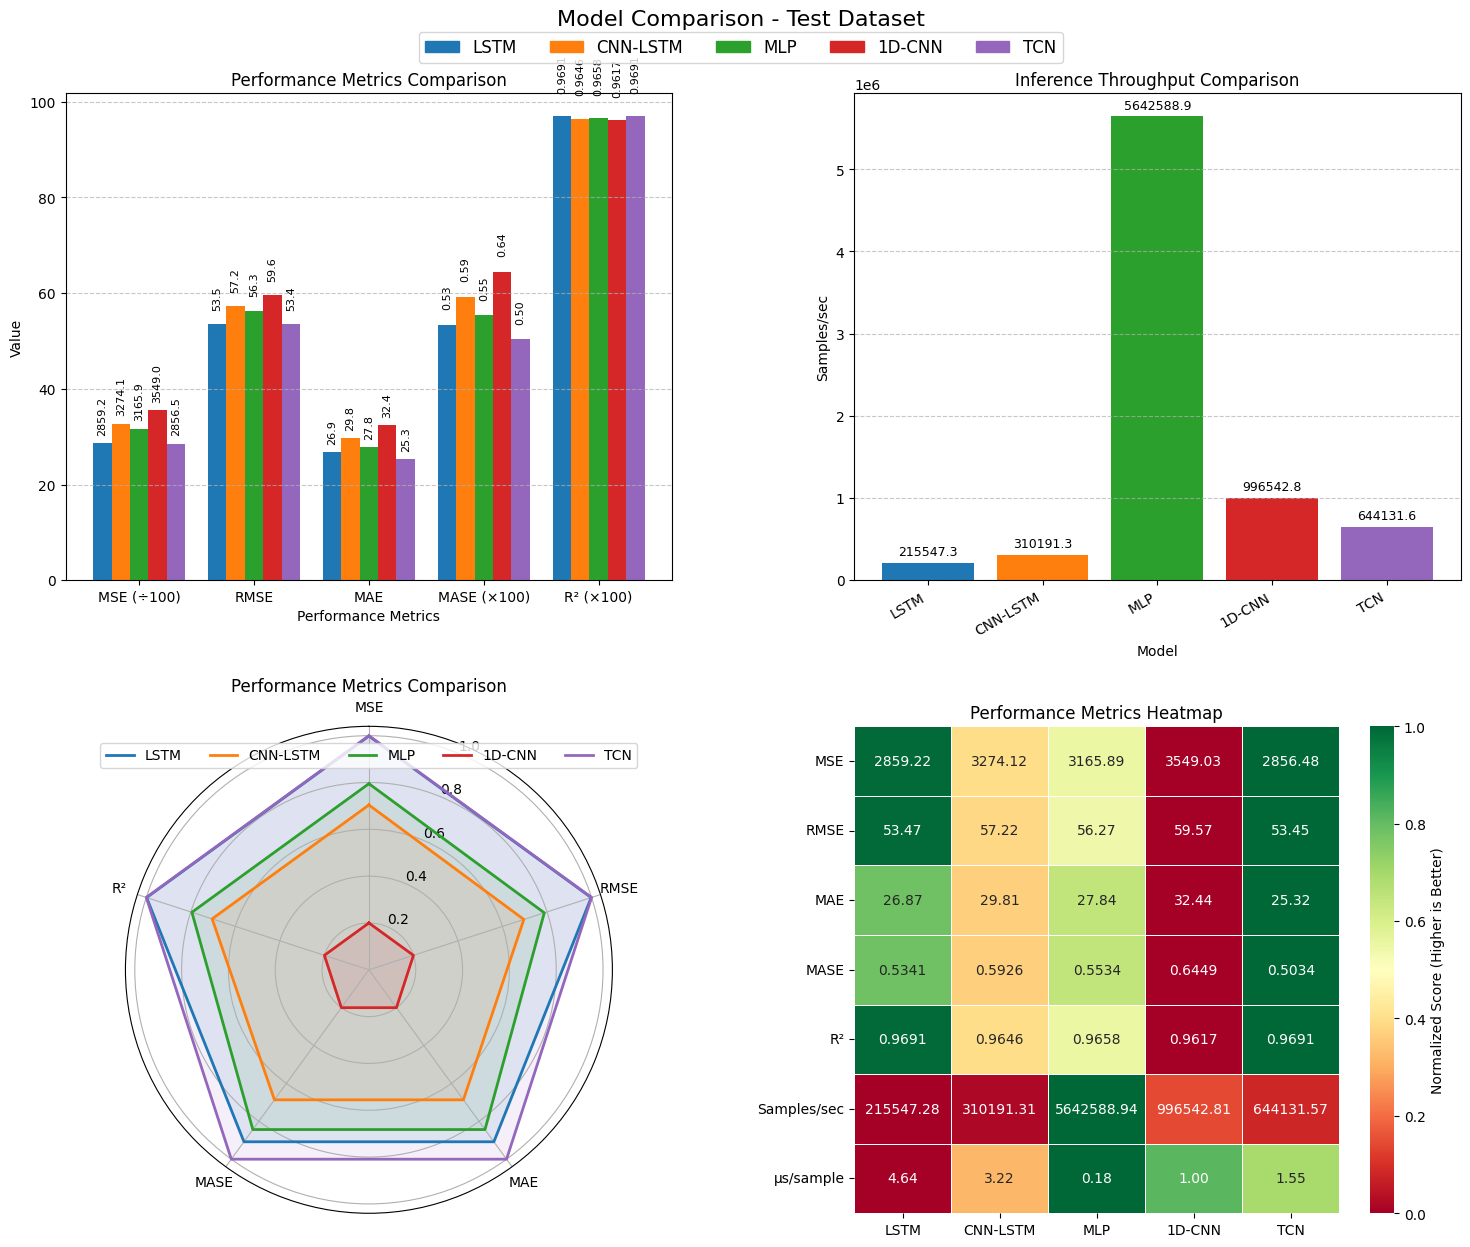

In [18]:
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'LSTM': lstm_test_metrics,
    'CNN-LSTM': cnn_lstm_test_metrics,
    'MLP': mlp_test_metrics,
    '1D-CNN': cnn1d_test_metrics,
    'TCN': tcn_test_metrics
}
# Drop the 'y_pred' and 'y_true' keys from the model metrics
for model in model_metrics:
    model_metrics[model].pop('y_pred', None)
    model_metrics[model].pop('y_true', None)
    model_metrics[model].pop('nighttime_mask', None)

# Save model metrics to a json file for later use
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_file_path = f'plots/basic_model_metrics_{timestamp}.json'
# Fix TypeError: Object of type float32 is not JSON serializable
for model in model_metrics:
    for key, value in model_metrics[model].items():
        if isinstance(value, np.float32):
            model_metrics[model][key] = float(value)
with open(json_file_path, 'w') as f:
    json.dump(model_metrics, f)

# Compare model performance on test set
fig = compare_models(model_metrics, dataset_name='Test')

## 4.2 Model Comparison on Daytime/Nighttime/Overall

Here we analyze model performance separately for daytime and nighttime periods. This is crucial for solar forecasting
as prediction requirements and patterns differ significantly between day and night. The comparison helps identify
which models perform better under different lighting conditions.

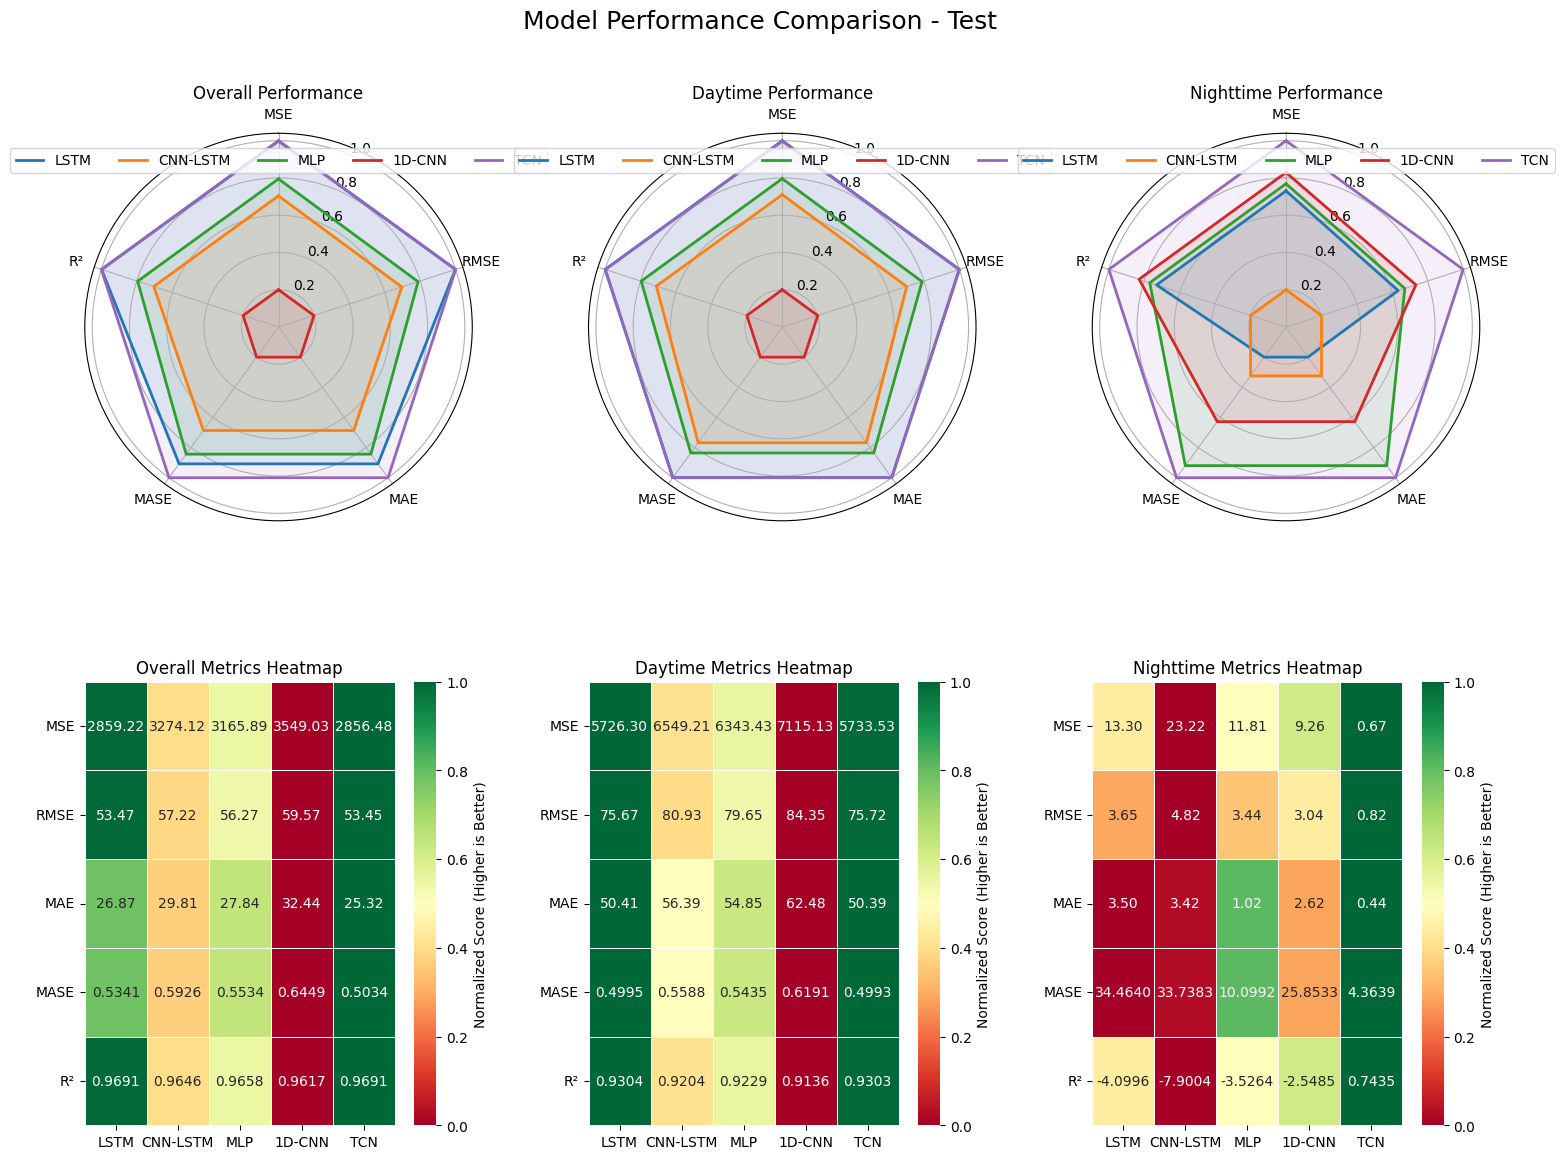

In [19]:
from utils.plot_utils import compare_models_daytime_nighttime

# Generate the comparison plot
comparison_fig = compare_models_daytime_nighttime(model_metrics, dataset_name='Test')

## 5. Visualization and Analysis

This section provides visual analysis of model predictions to better understand model performance.

### 5.1 Time Series Predictions

Visualize predictions over time to compare how each model tracks the actual GHI values. This visualization includes:
- Actual GHI values (ground truth)
- Predictions from each model
- Nighttime periods shaded for context
- Error metrics for the visualized time period

In [20]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models with nighttime shading if available

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []
    all_nighttime = []
    all_time_index_local = []
    has_nighttime = False
    has_time_index_local = False

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])
        # Check if nighttime data is available
        if 'nighttime_mask' in batch:
            has_nighttime = True
            all_nighttime.append(batch['nighttime_mask'])
        # Check if time_index_local is available
        if 'time_index_local' in batch:
            has_time_index_local = True
            # Store the time index values as they are
            if isinstance(batch['time_index_local'], list):
                all_time_index_local.extend(batch['time_index_local'])
            else:
                all_time_index_local.append(batch['time_index_local'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    if has_nighttime:
        all_nighttime = torch.cat(all_nighttime, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    if has_nighttime:
        nighttime = all_nighttime[start_idx:start_idx+num_samples].cpu().numpy()
        # Ensure nighttime is a 1D array
        if len(nighttime.shape) > 1:
            nighttime = nighttime.flatten() if nighttime.shape[1] == 1 else nighttime[:,0]

    # Get time index for x-axis if available
    x_values = None
    if has_time_index_local and len(all_time_index_local) >= start_idx + num_samples:
        # Extract the time values for the plotting window
        x_values = all_time_index_local[start_idx:start_idx+num_samples]

        # Try to convert to datetime objects if they are strings
        if isinstance(x_values[0], str):
            try:
                # Try different datetime formats
                date_formats = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%Y-%m-%dT%H:%M:%S', '%Y%m%d%H%M%S']
                for date_format in date_formats:
                    try:
                        x_values = [datetime.strptime(t, date_format) for t in x_values]
                        print(f"Successfully parsed dates with format: {date_format}")
                        break
                    except ValueError:
                        continue

                # If we couldn't parse with any format, notify and use indices
                if isinstance(x_values[0], str):
                    print(f"Could not parse date format: {x_values[0]}, using indices instead")
                    x_values = None

            except (ValueError, TypeError) as e:
                # If conversion fails, fall back to using indices
                print(f"Error converting time_index_local to datetime: {e}, using indices instead")
                x_values = None

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # Define colors and line styles for predictions
    colors = ['blue', 'red', 'green', 'magenta', 'cyan', 'orange']
    line_styles = ['--', ':', '-.', '--', ':', '--']

    # Set x-axis values based on availability of time_index_local
    if x_values:
        # Plot actual values with time index
        actual_line, = plt.plot(x_values, y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions with time index
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(x_values, pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # Format the x-axis to show dates properly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=0)  # Make labels horizontal
        fig.subplots_adjust(bottom=0.15)  # Adjust bottom margin for horizontal labels

        # If we have nighttime data, shade those regions
        if has_nighttime:
            # Modify nighttime shading to work with datetime x-axis
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                if start < len(x_values) and end <= len(x_values):
                    ax.axvspan(x_values[start], x_values[min(end, len(x_values)-1)],
                              alpha=0.2, color='gray', label='_nolegend_')
    else:
        # Use default integer indices for x-axis
        actual_line, = plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions and collect handles/labels
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # If we have nighttime data, shade those regions
        if has_nighttime:
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                ax.axvspan(start, end, alpha=0.2, color='gray', label='_nolegend_')

    # Add nighttime legend if applicable
    if has_nighttime and len(night_regions) > 0:
        night_patch = Patch(facecolor='gray', alpha=0.2, label='Nighttime')
        handles.append(night_patch)
        labels.append('Nighttime')

    # Calculate and display error metrics for the visualization window
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        rmse = np.sqrt(np.mean((y_true_orig - pred) ** 2))
        mae = np.mean(np.abs(y_true_orig - pred))
        plt.annotate(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}",
                     xy=(0.02, 0.97 - 0.03*i),
                     xycoords='axes fraction',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time' if x_values else 'Time Step')
    plt.ylabel('GHI (W/m²)')

    # Set the legend with the correct handles and labels
    plt.legend(handles, labels, loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    # Save the figure
    os.makedirs('plots', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'plots/predictions_over_time_{timestamp}.png')
    return fig

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


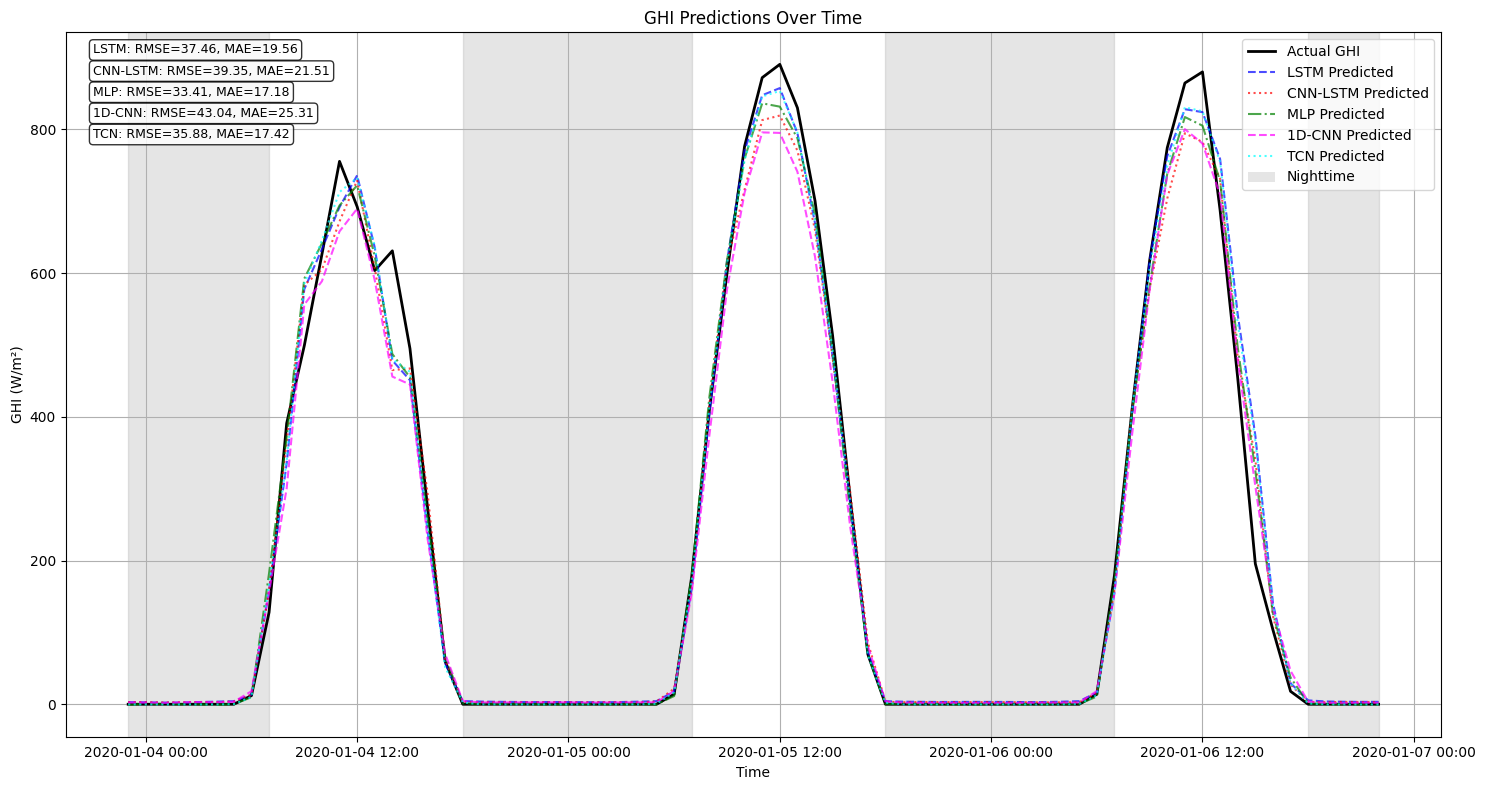

In [21]:
# Plot time series predictions
_ = plot_predictions_over_time(
    models=[lstm_model, cnn_lstm_model, mlp_model, cnn1d_model, tcn_model],
    model_names=['LSTM', 'CNN-LSTM', 'MLP', '1D-CNN', 'TCN'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=72,
    start_idx=40
)